>---                                                                                                                                          
> ## 1. Introduction and Dataset Overview
>
> Pourpose: Use two different machine learning models (the XGBoost model and Random Forest + Logistic Regression) to predict the peak energy consumption based on weather and time variables.
>
> Features:
>
> Target: peak_energy_consumption
>
> Data format: CSV
>
> Data collection: The data was acquired using multiple smart meter devices communicating readings every 15 min to a central server.
                   The measurements were collected between 05/05/2022 to 02/09/2023 in 172 different houses, located in the same parish (Loureiro, Oliveira de Azeméis) in the north of the Aveiro district, Portugal. All the collected data was included without any pre-processing.
>
>
> Direct URL to data: https://data.mendeley.com/datasets/vryvyfz2tj/1
>
>---

In [54]:
# Libraries
import pandas as pd
import numpy as np
import os # Library for interacting with the operating system

# Visualizations
import seaborn as sns
import matplotlib.pyplot as plt

# Machine Learning
from sklearn.model_selection import train_test_split
from sklearn.model_selection import RandomizedSearchCV
from xgboost                 import XGBClassifier
from sklearn.metrics         import classification_report, confusion_matrix, precision_recall_curve, f1_score
from sklearn.model_selection import StratifiedKFold

## 1. Loading Data

In [55]:
# code used to find the directory of the csv files
print("directory:", os.getcwd())
print("objects in that directory:", os.listdir())

directory: /Users/annycaroline/Downloads/ML Project/Classification Model
objects in that directory: ['energy_comsuption_prediction.ipynb', '.DS_Store', 'roc_auc_comparison.png', 'energy.ipynb', 'dataset', 'confusion_matrix_ensamble.png', 'confusion_matrix_xgb.png', 'correlation_crest_clean.png', 'pr_comparison.png', 'energy_consumption_air_temp.png', 'energy_peaks_day_hours.png', 'energy_consumption_humiduty_month.png', 'weather.ipynb', 'energy_consumption_distribution.png', 'feature_importance.png', 'energy_consumption_air_time.png', 'daily_energy_consumption_temp.png', 'energy_consumption_radiation.png', 'energy_consumption_wind.png', 'bar_peak_vs_normal_red_peak.png', 'energy_consumption_rad_time.png', 'daily_energy_consumption_weekday.png']


In [56]:
# load datasets
energy_data = pd.read_csv('./dataset/energy_pt_cleaned.csv')
weather_data = pd.read_csv('./dataset/weather_pt_cleaned.csv')    

In [57]:
#combine the two datasets 
merged = pd.merge(energy_data, weather_data, on='Time')

---
## 2. Data Preprocessing and Cleaning

### 2.1 Initial Exploration

In [58]:
# showing general information about the dataset
merged_info = merged.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 8000 entries, 0 to 7999
Data columns (total 11 columns):
 #   Column                    Non-Null Count  Dtype  
---  ------                    --------------  -----  
 0   Time                      8000 non-null   object 
 1   Total_Energy_Consumption  8000 non-null   float64
 2   Avg_Temp                  8000 non-null   float64
 3   Avg_Rel_Humidity          8000 non-null   float64
 4   Avg_Wind_Direction        8000 non-null   float64
 5   Avg_Wind_Speed            8000 non-null   float64
 6   Max_Inst_Wind_Speed       8000 non-null   float64
 7   Inst_Temp                 8000 non-null   float64
 8   Quantity_Precip           8000 non-null   float64
 9   Max_Inst_Precip           8000 non-null   float64
 10  Total_Global_Rad          8000 non-null   float64
dtypes: float64(10), object(1)
memory usage: 687.6+ KB


In [59]:
# showing general information about first 4 rows of dataset
merged.head()

,Time,Total_Energy_Consumption,Avg_Temp,Avg_Rel_Humidity,Avg_Wind_Direction,Avg_Wind_Speed,Max_Inst_Wind_Speed,Inst_Temp,Quantity_Precip,Max_Inst_Precip,Total_Global_Rad
0,2022-05-05 12:00:00,9.036,22.70,62.0,305.0,3.80,5.40,24.40,0.0,0.0,526.00
1,2022-05-05 12:15:00,9.613,22.55,63.5,311.5,4.05,5.70,24.55,0.0,0.0,523.35
2,2022-05-05 12:30:00,10.160,22.10,64.0,311.0,4.10,6.00,24.80,0.0,0.0,520.00
3,2022-05-05 12:45:00,10.143,21.95,62.5,300.0,4.45,6.05,24.90,0.0,0.0,514.40
4,2022-05-05 13:00:00,9.850,22.20,62.0,314.0,4.00,5.20,24.90,0.0,0.0,507.00


---
### 2.2. Handling Missing Data

In [60]:
# All missing values was treated individualy for each dataset: energy_data and weather_data. 
# Only checking if the merged dataset there are missing values.  
print(merged.isnull().sum())

Time                        0
Total_Energy_Consumption    0
Avg_Temp                    0
Avg_Rel_Humidity            0
Avg_Wind_Direction          0
Avg_Wind_Speed              0
Max_Inst_Wind_Speed         0
Inst_Temp                   0
Quantity_Precip             0
Max_Inst_Precip             0
Total_Global_Rad            0
dtype: int64


### 2.3 Transformation 

`Transform date columns to datetime type`

In [61]:
merged['Time'] = pd.to_datetime(merged['Time'])

### 2.4 Feature Engeneering

In [62]:
merged['Hour'] = merged['Time'].dt.hour

merged['Hour'].unique()

array([12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23,  0,  1,  2,  3,  4,
        5,  6,  7,  8,  9, 10, 11], dtype=int32)

`Feature Engeneering Temporal`

In [63]:
# Extract time-based features
merged['Date']        = merged['Time'].dt.date
merged['Day_of_Week'] = merged['Time'].dt.dayofweek
merged['Month']       = merged['Time'].dt.month
merged["Hour"] = pd.to_datetime(merged["Time"]).dt.hour
merged['Minute']      = merged['Time'].dt.minute

# Weekend indicator (Saturday = 5, Sunday = 6)
merged['Weekend'] = merged['Day_of_Week'].isin([5, 6]).astype(int)

# New features based on common error patterns
merged['Is_Night'] = ((merged['Hour'] >= 18) | (merged['Hour'] <= 6)).astype(int)
merged['Is_Weekend_Night'] = (merged['Is_Night'] & (merged['Weekend'] == 1)).astype(int)

# Create composite feature: weekend night with low solar radiation
rad_threshold = merged['Total_Global_Rad'].quantile(0.25)  # 25th percentile

merged['Is_Weekend_Night_Low_Rad'] = (
    (merged['Is_Weekend_Night'] == 1) & (merged['Total_Global_Rad'] <= rad_threshold)
).astype(int)

# Optionally re-enable cyclic time features:
# merged['Hour_Sin'] = np.sin(2 * np.pi * merged['Hour'] / 24)
# merged['Hour_Cos'] = np.cos(2 * np.pi * merged['Hour'] / 24)

print(merged['Month'].value_counts())
print(merged['Minute'].value_counts()) 

Month
6    2880
7    2576
5    2544
Name: count, dtype: int64
Minute
0     2000
15    2000
30    2000
45    2000
Name: count, dtype: int64


`Lag features (curto prazo)`

In [64]:
# Criar lags
merged['Lag_1H'] = merged['Total_Energy_Consumption'].shift(1)
merged['Lag_2H'] = merged['Total_Energy_Consumption'].shift(2)

# Fill the NaNs with the average of the original column itself
mean_consumption = merged['Total_Energy_Consumption'].mean()
merged['Lag_1H'].fillna(mean_consumption, inplace=True)
merged['Lag_2H'].fillna(mean_consumption, inplace=True)


/var/folders/xj/vmtsvzgs6zj1l876xt4q0nkw0000gn/T/ipykernel_41074/2449295877.py:7: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  merged['Lag_1H'].fillna(mean_consumption, inplace=True)
/var/folders/xj/vmtsvzgs6zj1l876xt4q0nkw0000gn/T/ipykernel_41074/2449295877.py:8: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting valu

`Rolling features Trends local of the consumption`

In [65]:
merged['Rolling_Mean_3H'] = merged['Total_Energy_Consumption'].rolling(3).mean()
merged['Rolling_Std_3H']  = merged['Total_Energy_Consumption'].rolling(3).std()

# Fill with average
merged['Rolling_Mean_3H'].fillna(merged['Total_Energy_Consumption'].mean(), inplace=True)
merged['Rolling_Std_3H'].fillna(merged['Rolling_Std_3H'].mean(), inplace=True)

/var/folders/xj/vmtsvzgs6zj1l876xt4q0nkw0000gn/T/ipykernel_41074/932264647.py:5: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  merged['Rolling_Mean_3H'].fillna(merged['Total_Energy_Consumption'].mean(), inplace=True)
/var/folders/xj/vmtsvzgs6zj1l876xt4q0nkw0000gn/T/ipykernel_41074/932264647.py:6: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate obj

In [66]:
merged[['Lag_1H', 'Lag_2H', 'Rolling_Mean_3H', 'Rolling_Std_3H']] = \
merged[['Lag_1H', 'Lag_2H', 'Rolling_Mean_3H', 'Rolling_Std_3H']].fillna(method='bfill')

/var/folders/xj/vmtsvzgs6zj1l876xt4q0nkw0000gn/T/ipykernel_41074/2956601344.py:2: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  merged[['Lag_1H', 'Lag_2H', 'Rolling_Mean_3H', 'Rolling_Std_3H']].fillna(method='bfill')


`Diff. Temperature`

In [67]:
merged['Diff_Temp'] = merged['Avg_Temp'].diff().fillna(0)
merged['Diff_Temp'].value_counts(dropna=False)

Diff_Temp
 0.00    875
-0.05    638
 0.05    405
-0.10    395
-0.25    375
        ... 
 0.90      1
-0.80      1
 1.60      1
-1.90      1
 1.45      1
Name: count, Length: 194, dtype: int64

`Feature Engeneering Sanzonal`

In [68]:
# Sazonal
merged['Season'] = merged['Month'].apply(lambda x: 'Spring' if x == 5 else 'Summer')
merged['Season'].value_counts()

Season
Summer    5456
Spring    2544
Name: count, dtype: int64

`Feature Engeneering Forecast Condition`

In [69]:
# Compute the 10th/90th percentiles
q_low_temp   = merged['Avg_Temp']           .quantile(0.10)
q_high_temp  = merged['Avg_Temp']           .quantile(0.90)
q_low_rad    = merged['Total_Global_Rad']   .quantile(0.10)
q_high_rad   = merged['Total_Global_Rad']   .quantile(0.90)
q_high_wind  = merged['Avg_Wind_Speed']     .quantile(0.90)

# Build a single “climate condition” column
conditions = [
    merged['Avg_Temp']        <= q_low_temp,
    merged['Avg_Temp']        >= q_high_temp,
    merged['Total_Global_Rad'] <= q_low_rad,
    merged['Total_Global_Rad'] >= q_high_rad,
    merged['Avg_Wind_Speed']  >= q_high_wind,
]
choices = [
    'Cold_Extreme',
    'Hot_Extreme',
    'Low_Radiation',
    'High_Radiation',
    'High_Wind'
]

merged['Climate_Condition'] = np.select(conditions, choices, default='Normal')

# Inspect the new column
print(merged['Climate_Condition'].value_counts())

Climate_Condition
Normal            3043
Low_Radiation     2238
Cold_Extreme       809
Hot_Extreme        801
High_Radiation     597
High_Wind          512
Name: count, dtype: int64


In [70]:
# Define a mapping from categories to integers
mapping = {
    'Normal': 0,
    'Low_Radiation': 1,
    'Cold_Extreme': 2,
    'Hot_Extreme': 3,
    'High_Radiation': 4,
    'High_Wind': 5
}

# Create a new column with the integer codes
merged['Climate_Condition_Code'] = merged['Climate_Condition'].map(mapping).astype('int64')

#count variables
print(merged[['Climate_Condition_Code']].value_counts())

Climate_Condition_Code
0                         3043
1                         2238
2                          809
3                          801
4                          597
5                          512
Name: count, dtype: int64


`Feature Engeneering Peak Energy Consumption`

In [71]:
# extract hour
merged['Hour'] = merged['Time'].dt.hour

# get that hour’s own 75% threshold
merged['Hourly_Q75'] = merged.groupby('Hour')['Total_Energy_Consumption'] \
                     .transform(lambda x: x.quantile(0.75))

# flag peaks relative to its hour
merged['Peak_Consumption'] = (merged['Total_Energy_Consumption'] > merged['Hourly_Q75']).astype(int)


In [72]:
print(merged.isnull().sum())

Time                        0
Total_Energy_Consumption    0
Avg_Temp                    0
Avg_Rel_Humidity            0
Avg_Wind_Direction          0
Avg_Wind_Speed              0
Max_Inst_Wind_Speed         0
Inst_Temp                   0
Quantity_Precip             0
Max_Inst_Precip             0
Total_Global_Rad            0
Hour                        0
Date                        0
Day_of_Week                 0
Month                       0
Minute                      0
Weekend                     0
Is_Night                    0
Is_Weekend_Night            0
Is_Weekend_Night_Low_Rad    0
Lag_1H                      0
Lag_2H                      0
Rolling_Mean_3H             0
Rolling_Std_3H              0
Diff_Temp                   0
Season                      0
Climate_Condition           0
Climate_Condition_Code      0
Hourly_Q75                  0
Peak_Consumption            0
dtype: int64


`Encoding`

In [73]:
# Encode categorical variables (Season, Climate_Condition)
merged = pd.get_dummies(
    merged,
    columns=['Season'],
    drop_first=True,
    dtype=int
)

# Verify new column names
print(merged.columns)

Index(['Time', 'Total_Energy_Consumption', 'Avg_Temp', 'Avg_Rel_Humidity',
       'Avg_Wind_Direction', 'Avg_Wind_Speed', 'Max_Inst_Wind_Speed',
       'Inst_Temp', 'Quantity_Precip', 'Max_Inst_Precip', 'Total_Global_Rad',
       'Hour', 'Date', 'Day_of_Week', 'Month', 'Minute', 'Weekend', 'Is_Night',
       'Is_Weekend_Night', 'Is_Weekend_Night_Low_Rad', 'Lag_1H', 'Lag_2H',
       'Rolling_Mean_3H', 'Rolling_Std_3H', 'Diff_Temp', 'Climate_Condition',
       'Climate_Condition_Code', 'Hourly_Q75', 'Peak_Consumption',
       'Season_Summer'],
      dtype='object')


In [74]:
df = merged.copy()

# Columns to check for outliers
clients_cols = [
    'Avg_Temp', 'Avg_Rel_Humidity', 'Avg_Wind_Speed',
    'Max_Inst_Wind_Speed', 'Inst_Temp', 'Total_Global_Rad',
    'Total_Energy_Consumption'
]

# Function to iteratively remove outliers based on the IQR method
def remove_outliers_iteratively(df, cols, iqr_factor=1.5):
    outliers_found = True
    while outliers_found:
        outliers_found = False
        for col in cols:
            q1 = df[col].quantile(0.25)
            q3 = df[col].quantile(0.75)
            iqr = q3 - q1
            ll = q1 - iqr_factor * iqr  # Lower limit
            ul = q3 + iqr_factor * iqr  # Upper limit
            
            # Identify outliers
            outliers = df[(df[col] < ll) | (df[col] > ul)]
            if len(outliers) > 0:
                outliers_found = True
                print(f'Outliers in column {col}: {len(outliers)}')
                
                # Remove the outliers
                df = df[(df[col] >= ll) & (df[col] <= ul)]
    return df

# Iteratively remove outliers
df_cleaned = remove_outliers_iteratively(df.copy(), clients_cols)

# Verify remaining outliers (e.g. by re-computing IQR bounds)
for col in clients_cols:
    q1 = df_cleaned[col].quantile(0.25)
    q3 = df_cleaned[col].quantile(0.75)
    iqr = q3 - q1
    ll = q1 - 1.5 * iqr
    ul = q3 + 1.5 * iqr
    remaining_outliers = df_cleaned[(df_cleaned[col] < ll) | (df_cleaned[col] > ul)]
    print(f'Remaining outliers in column {col}: {len(remaining_outliers)}')

Outliers in column Avg_Temp: 279
Outliers in column Avg_Rel_Humidity: 108
Outliers in column Avg_Wind_Speed: 67
Outliers in column Max_Inst_Wind_Speed: 40
Outliers in column Inst_Temp: 26
Outliers in column Total_Energy_Consumption: 341
Outliers in column Avg_Temp: 82
Outliers in column Avg_Rel_Humidity: 18
Outliers in column Avg_Wind_Speed: 9
Outliers in column Max_Inst_Wind_Speed: 7
Outliers in column Inst_Temp: 25
Outliers in column Total_Energy_Consumption: 74
Outliers in column Avg_Temp: 33
Outliers in column Total_Energy_Consumption: 14
Outliers in column Total_Energy_Consumption: 2
Remaining outliers in column Avg_Temp: 0
Remaining outliers in column Avg_Rel_Humidity: 0
Remaining outliers in column Avg_Wind_Speed: 0
Remaining outliers in column Max_Inst_Wind_Speed: 0
Remaining outliers in column Inst_Temp: 0
Remaining outliers in column Total_Global_Rad: 0
Remaining outliers in column Total_Energy_Consumption: 0


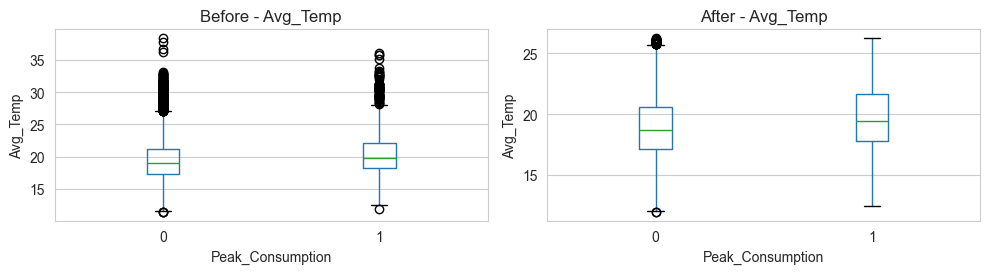

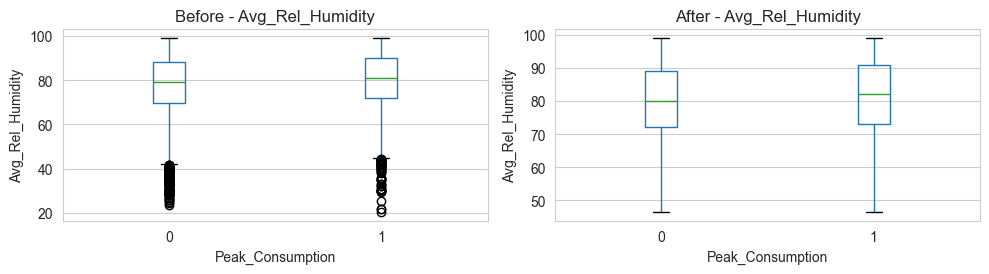

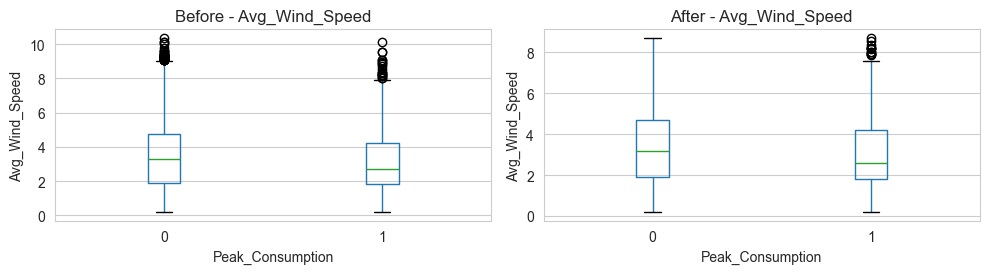

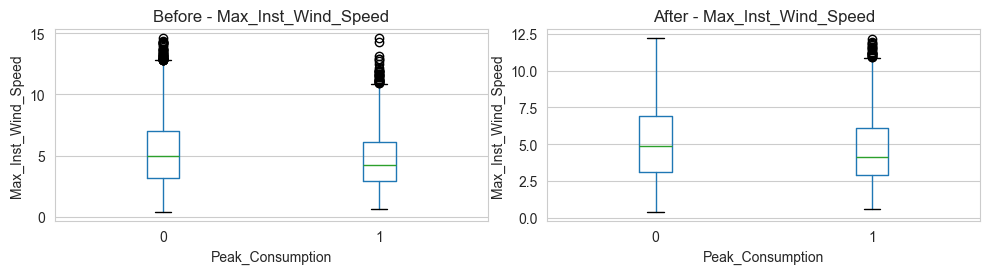

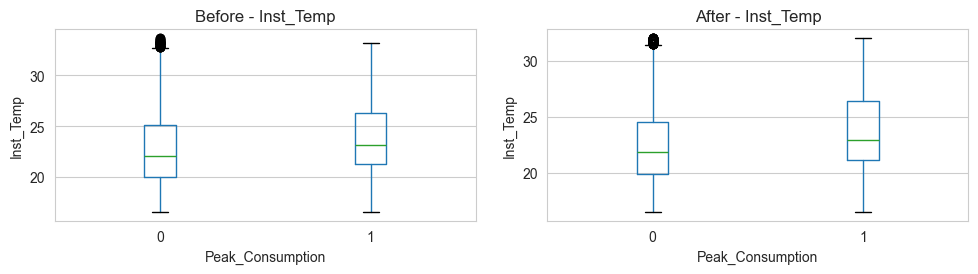

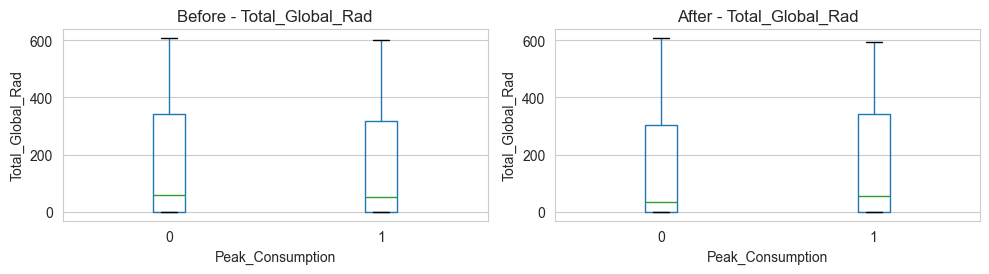

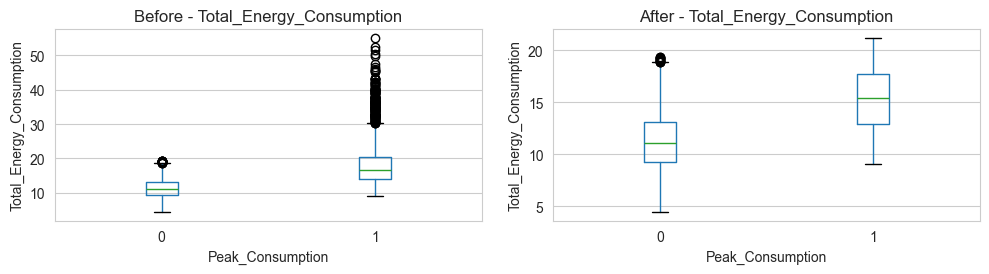

In [75]:
# Function to compare boxplots in your style

def compare_boxplots_custom(df, df_cleaned, columns, by=None):
    for col in columns:
        fig, axes = plt.subplots(1, 2, figsize=(10, 3))

        # Before the removal
        df.boxplot(column=col, by=by, ax=axes[0])
        axes[0].set_title(f'Before - {col}')
        axes[0].set_ylabel(col.title())
        if by:
            axes[0].set_xlabel(by.title())
        axes[0].grid(axis='x')

        # After the removal
        df_cleaned.boxplot(column=col, by=by, ax=axes[1])
        axes[1].set_title(f'After - {col}')
        axes[1].set_ylabel(col.title())
        if by:
            axes[1].set_xlabel(by.title())
        axes[1].grid(axis='x')

        plt.suptitle('')
        plt.tight_layout()
        plt.show()

# Run the comparison
compare_boxplots_custom(df, df_cleaned, clients_cols, by='Peak_Consumption')

--- 
### 3. Exploratory Data Analysis (EDA)

In [76]:
# Descriptive statistics grouped by each condition
print("\nStatistical Summary:")
print(df_cleaned.describe())


Statistical Summary:
                                Time  Total_Energy_Consumption     Avg_Temp  \
count                           6875               6875.000000  6875.000000   
mean   2022-06-14 20:31:21.294545408                 12.137387    19.077113   
min              2022-05-05 12:00:00                  4.467000    11.950000   
25%              2022-05-24 01:07:30                  9.659250    17.300000   
50%              2022-06-12 20:45:00                 11.635400    18.900000   
75%              2022-07-04 20:52:30                 14.266500    20.900000   
max              2022-07-27 18:30:00                 21.150250    26.250000   
std                              NaN                  3.257280     2.659002   

       Avg_Rel_Humidity  Avg_Wind_Direction  Avg_Wind_Speed  \
count       6875.000000         6875.000000     6875.000000   
mean          79.908145          224.183273        3.406422   
min           46.500000            0.000000        0.200000   
25%           

### 3.1 Visualizations:

`Averange Relative Humidity (%) vs Avarenge Energy Consumption (kWh)`

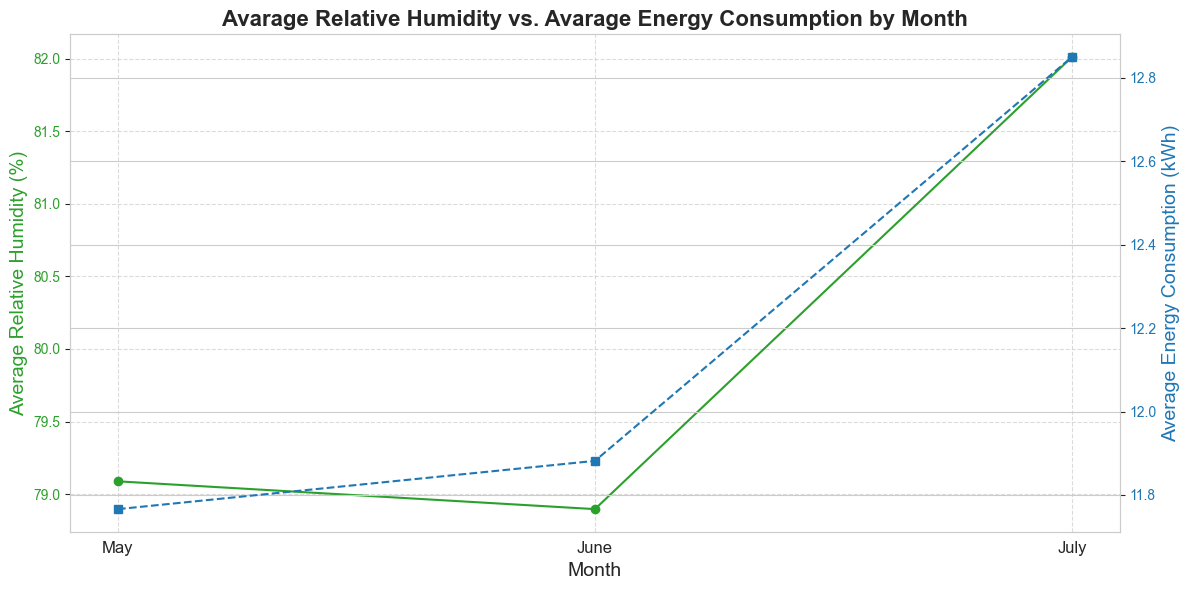

In [77]:
# Group by month
monthly_summary = df_cleaned.groupby('Month').agg({
    'Avg_Rel_Humidity': 'mean',
    'Total_Energy_Consumption': 'mean'
}).reset_index()

# Month labels (adjusted to English names)
month_labels = ['May', 'June', 'July']

# Create figure and axes
fig, ax1 = plt.subplots(figsize=(12, 6))

# Set white background
fig.patch.set_facecolor('white')
ax1.set_facecolor('white')

# Plot Relative Humidity
ax1.set_xlabel("Month", fontsize=14)
ax1.set_ylabel("Average Relative Humidity (%)", color='tab:green', fontsize=14)
ax1.plot(monthly_summary['Month'], monthly_summary['Avg_Rel_Humidity'],
         color='tab:green', marker='o', label='Relative Humidity')
ax1.tick_params(axis='y', labelcolor='tab:green')

# Plot Energy Consumption
ax2 = ax1.twinx()
ax2.set_ylabel("Average Energy Consumption (kWh)", color='tab:blue', fontsize=14)
ax2.plot(monthly_summary['Month'], monthly_summary['Total_Energy_Consumption'],
         color='tab:blue', marker='s', linestyle='--', label='Energy Consumption')
ax2.tick_params(axis='y', labelcolor='tab:blue')

# Set month labels on x-axis
ax1.set_xticks(monthly_summary['Month'])
ax1.set_xticklabels(month_labels, fontsize=12)

# Title and grid
plt.title("Avarage Relative Humidity vs. Avarage Energy Consumption by Month", fontsize=16, weight='bold')
ax1.grid(True, linestyle='--', alpha=0.7)

# Layout
plt.tight_layout()
plt.savefig('energy_consumption_humiduty_month.png', dpi=300)
plt.show()

`Air Temperatura Média  (°C) vs Total Energy Consumption`

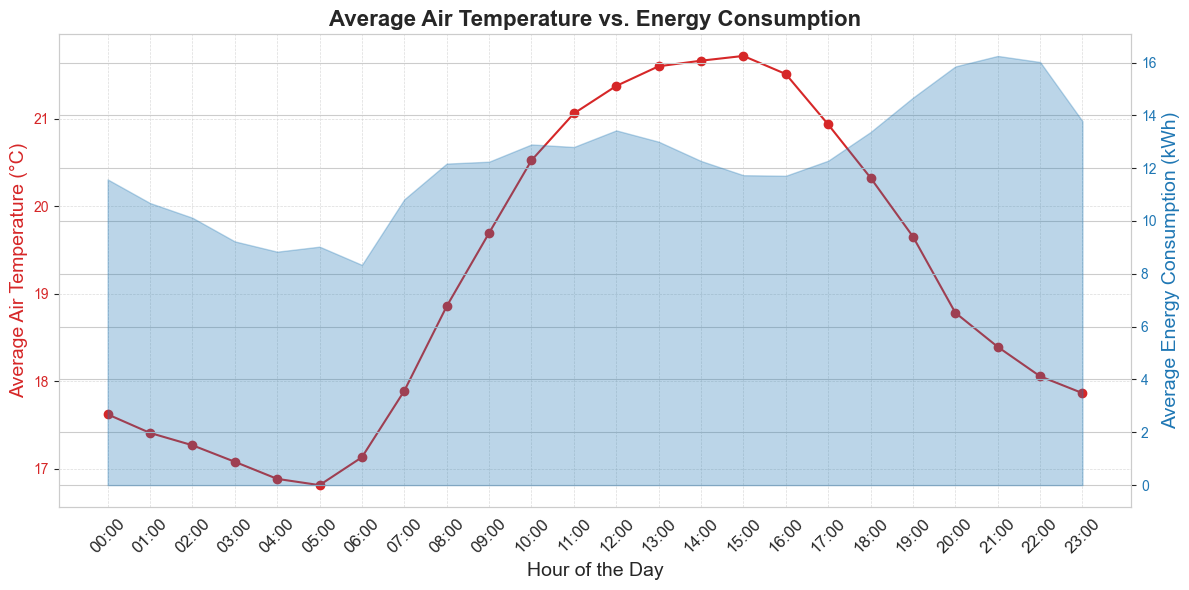

In [78]:
# Group by hour of the day
hourly_summary = df_cleaned.groupby('Hour').agg({
    'Avg_Temp': 'mean',
    'Total_Energy_Consumption': 'mean'
}).reset_index()

# Convert to arrays
x_hour = hourly_summary['Hour'].to_numpy(dtype=np.float64)
y_temp = hourly_summary['Avg_Temp'].to_numpy(dtype=np.float64)
y_energy = hourly_summary['Total_Energy_Consumption'].to_numpy(dtype=np.float64)

# Create hour labels ("00:00", "01:00", etc.)
hour_labels = [f"{int(h):02d}:00" for h in x_hour]

# Plotting
fig, ax1 = plt.subplots(figsize=(12, 6))

# Set white background
fig.patch.set_facecolor('white')
ax1.set_facecolor('white')

# Average Air Temperature (red line)
ax1.set_xlabel("Hour of the Day", fontsize=14)
ax1.set_ylabel("Average Air Temperature (°C)", color='tab:red', fontsize=14)
ax1.plot(x_hour, y_temp, color='tab:red', marker='o')
ax1.tick_params(axis='y', labelcolor='tab:red')

# Average Energy Consumption (blue area)
ax2 = ax1.twinx()
ax2.set_ylabel("Average Energy Consumption (kWh)", color='tab:blue', fontsize=14)
ax2.fill_between(x_hour, y_energy, color='tab:blue', alpha=0.3)
ax2.tick_params(axis='y', labelcolor='tab:blue')

# Hour labels
ax1.set_xticks(x_hour)
ax1.set_xticklabels(hour_labels, rotation=45, fontsize=12)

# Title and grid
plt.title("Average Air Temperature vs. Energy Consumption", fontsize=16, weight='bold')
ax1.grid(True, linestyle='--', linewidth=0.5, alpha=0.7)

plt.tight_layout()
plt.savefig('energy_consumption_air_time.png', dpi=300)
plt.show()

`Relationship between Total global Radiation and Energy Consumption throughout the Day`

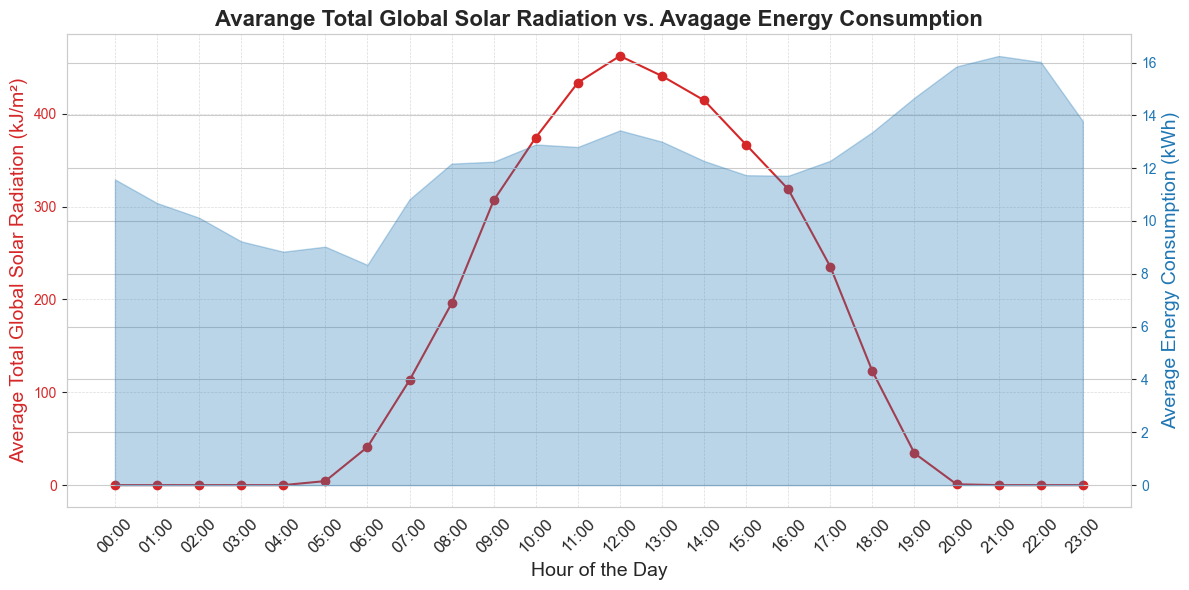

In [79]:
# Group by hour of the day
hourly_summary = df_cleaned.groupby('Hour').agg({
    'Total_Global_Rad': 'mean',
    'Total_Energy_Consumption': 'mean'
}).reset_index()

# Convert data to arrays
x_hour = hourly_summary['Hour'].to_numpy(dtype=np.float64)
y_rad = hourly_summary['Total_Global_Rad'].to_numpy(dtype=np.float64)
y_energy = hourly_summary['Total_Energy_Consumption'].to_numpy(dtype=np.float64)

# Create hour labels ("00:00", "01:00", etc.)
hour_labels = [f"{int(h):02d}:00" for h in x_hour]

# Plotting
fig, ax1 = plt.subplots(figsize=(12, 6))

# Set white background
fig.patch.set_facecolor('white')
ax1.set_facecolor('white')

# Plot Total Global Solar Radiation (red line)
ax1.set_xlabel("Hour of the Day", fontsize=14)
ax1.set_ylabel("Average Total Global Solar Radiation (kJ/m²)", color='tab:red', fontsize=14)
ax1.plot(x_hour, y_rad, color='tab:red', marker='o')
ax1.tick_params(axis='y', labelcolor='tab:red')

# Plot Energy Consumption (blue area)
ax2 = ax1.twinx()
ax2.set_ylabel("Average Energy Consumption (kWh)", color='tab:blue', fontsize=14)
ax2.fill_between(x_hour, y_energy, color='tab:blue', alpha=0.3)
ax2.tick_params(axis='y', labelcolor='tab:blue')

# Configure X-axis labels
ax1.set_xticks(x_hour)
ax1.set_xticklabels(hour_labels, rotation=45, fontsize=12)

# Title and grid
plt.title("Avarange Total Global Solar Radiation vs. Avagage Energy Consumption", fontsize=16, weight='bold')
ax1.grid(True, linestyle='--', linewidth=0.5, alpha=0.7)

plt.tight_layout()
plt.savefig('energy_consumption_rad_time.png', dpi=300)
plt.show()

In [80]:
df_cleaned.columns

Index(['Time', 'Total_Energy_Consumption', 'Avg_Temp', 'Avg_Rel_Humidity',
       'Avg_Wind_Direction', 'Avg_Wind_Speed', 'Max_Inst_Wind_Speed',
       'Inst_Temp', 'Quantity_Precip', 'Max_Inst_Precip', 'Total_Global_Rad',
       'Hour', 'Date', 'Day_of_Week', 'Month', 'Minute', 'Weekend', 'Is_Night',
       'Is_Weekend_Night', 'Is_Weekend_Night_Low_Rad', 'Lag_1H', 'Lag_2H',
       'Rolling_Mean_3H', 'Rolling_Std_3H', 'Diff_Temp', 'Climate_Condition',
       'Climate_Condition_Code', 'Hourly_Q75', 'Peak_Consumption',
       'Season_Summer'],
      dtype='object')

`Total energy consumption extreme events`

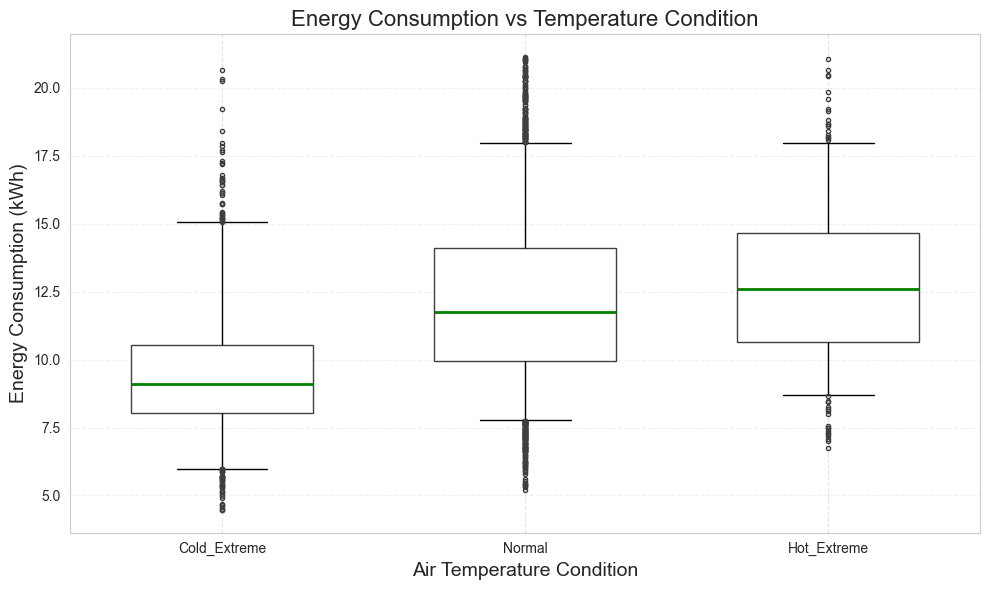

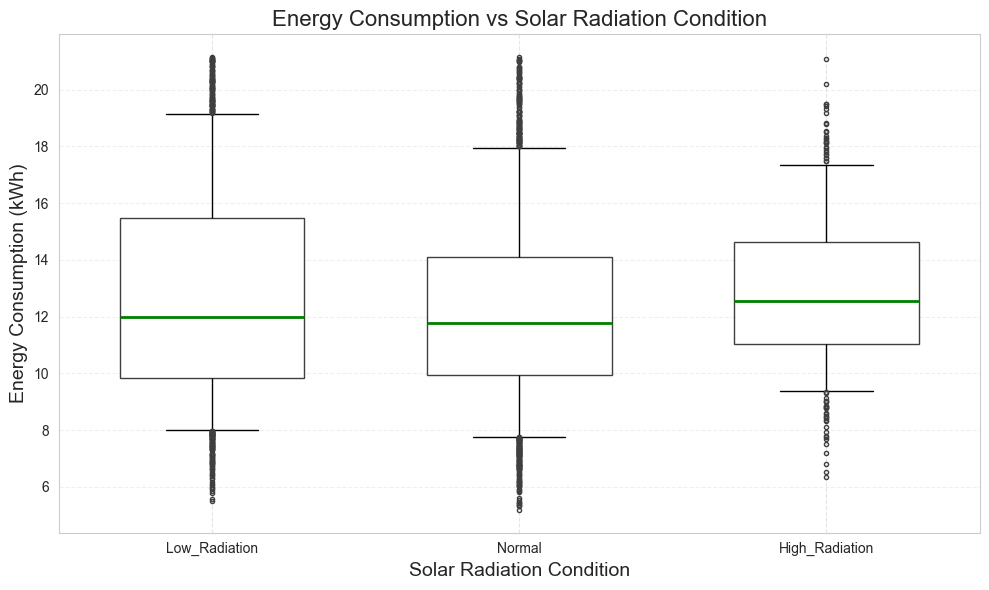

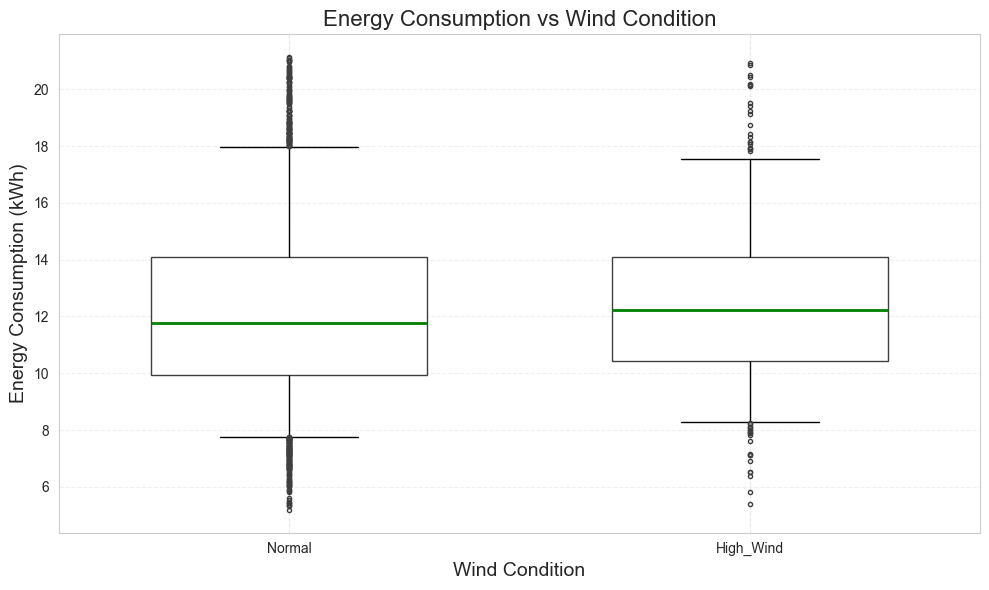

In [81]:
sns.set_style('whitegrid')

# 1) Boxplot: Energy Consumption by Temperature Condition
plt.figure(figsize=(10, 6))
ax = sns.boxplot(
    x='Climate_Condition',
    y='Total_Energy_Consumption',
    data=df_cleaned,
    order=['Cold_Extreme', 'Normal', 'Hot_Extreme'],
    whis=[5, 95],
    width=0.6,
    fliersize=3,
    boxprops={'facecolor': 'white'},
    medianprops={'color': 'green', 'linewidth': 2},
    whiskerprops={'color': 'black'},
    capprops={'color': 'black'}
)
ax.set_title('Energy Consumption vs Temperature Condition', fontsize=16)
ax.set_xlabel('Air Temperature Condition', fontsize=14)
ax.set_ylabel('Energy Consumption (kWh)', fontsize=14)
ax.xaxis.grid(True, linestyle='--', alpha=0.5)
ax.yaxis.grid(True, linestyle='--', alpha=0.3)
plt.tight_layout()
plt.savefig('energy_consumption_air_temp.png', dpi=300)
plt.show()


# 2) Boxplot: Energy Consumption by Solar Radiation Condition
plt.figure(figsize=(10, 6))
ax = sns.boxplot(
    x='Climate_Condition',
    y='Total_Energy_Consumption',
    data=df_cleaned,
    order=['Low_Radiation', 'Normal', 'High_Radiation'],
    whis=[5, 95],
    width=0.6,
    fliersize=3,
    boxprops={'facecolor': 'white'},
    medianprops={'color': 'green', 'linewidth': 2},
    whiskerprops={'color': 'black'},
    capprops={'color': 'black'}
)
ax.set_title('Energy Consumption vs Solar Radiation Condition', fontsize=16)
ax.set_xlabel('Solar Radiation Condition', fontsize=14)
ax.set_ylabel('Energy Consumption (kWh)', fontsize=14)
ax.xaxis.grid(True, linestyle='--', alpha=0.5)
ax.yaxis.grid(True, linestyle='--', alpha=0.3)
plt.tight_layout()
plt.savefig('energy_consumption_radiation.png', dpi=300)
plt.show()


# 3) Boxplot: Energy Consumption by Wind Condition
plt.figure(figsize=(10, 6))
ax = sns.boxplot(
    x='Climate_Condition',
    y='Total_Energy_Consumption',
    data=df_cleaned,
    order=['Normal', 'High_Wind'],
    whis=[5, 95],
    width=0.6,
    fliersize=3,
    boxprops={'facecolor': 'white'},
    medianprops={'color': 'green', 'linewidth': 2},
    whiskerprops={'color': 'black'},
    capprops={'color': 'black'}
)
ax.set_title('Energy Consumption vs Wind Condition', fontsize=16)
ax.set_xlabel('Wind Condition', fontsize=14)
ax.set_ylabel('Energy Consumption (kWh)', fontsize=14)
ax.xaxis.grid(True, linestyle='--', alpha=0.5)
ax.yaxis.grid(True, linestyle='--', alpha=0.3)
plt.tight_layout()
plt.savefig('energy_consumption_wind.png', dpi=300)
plt.show()

In [82]:
from matplotlib import gridspec
import calendar

`High Consumption  Distribution`

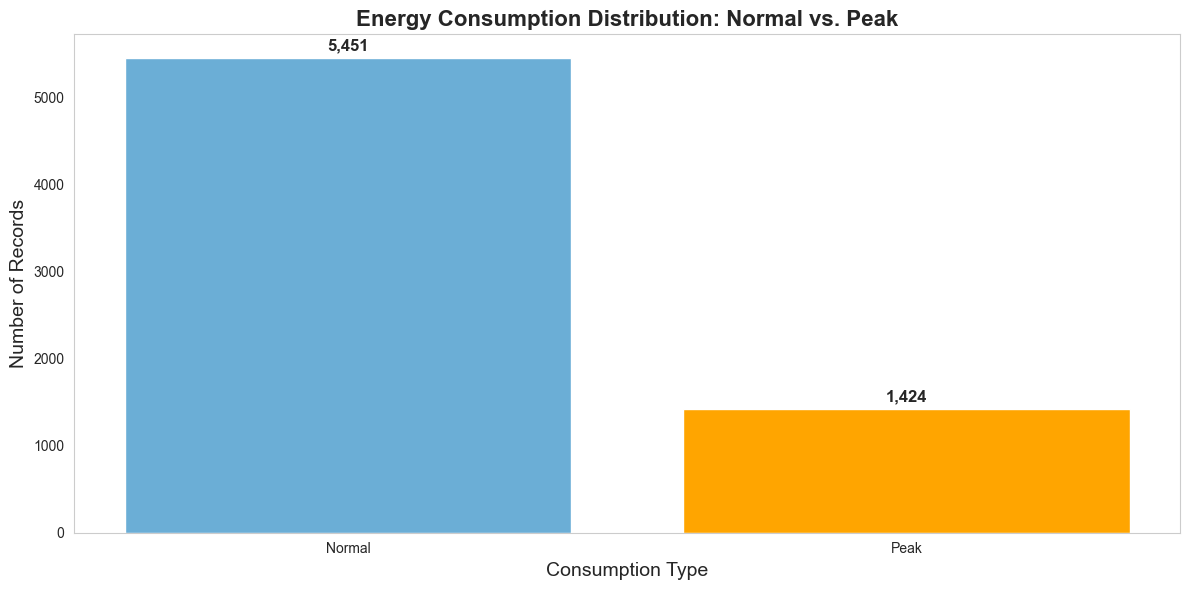

In [83]:
# 1) Prepare the data
target_analysis = df_cleaned.copy()
target_analysis['Peak_Consumption_label'] = target_analysis['Peak_Consumption'].map({
    0: 'Normal',
    1: 'Peak'
})

counts = target_analysis['Peak_Consumption_label'].value_counts()
labels = counts.index.tolist()
values = counts.values.tolist()

# Create the bar chart
fig, ax = plt.subplots(figsize=(12, 6), facecolor='white')
ax.set_facecolor('white')

# Use blue for Normal and red for Peak
bars = ax.bar(
    labels,
    values,
    color=['#6baed6', 'orange'],
    edgecolor='white',
    linewidth=1
)

# Annotate values above each bar
for bar in bars:
    height = bar.get_height()
    ax.text(
        bar.get_x() + bar.get_width() / 2,
        height + max(values) * 0.01,
        f'{height:,}',
        ha='center',
        va='bottom',
        fontsize=12,
        weight='bold'
    )

#  Final styling (no grid)
ax.set_title('Energy Consumption Distribution: Normal vs. Peak', fontsize=16, weight='bold')
ax.set_ylabel('Number of Records', fontsize=14)
ax.set_xlabel('Consumption Type', fontsize=14)

# Turn off any active grid
ax.grid(False)
ax.xaxis.grid(False)
ax.yaxis.grid(False)

plt.tight_layout()
plt.savefig('bar_peak_vs_normal_red_peak.png', dpi=300)
plt.show()

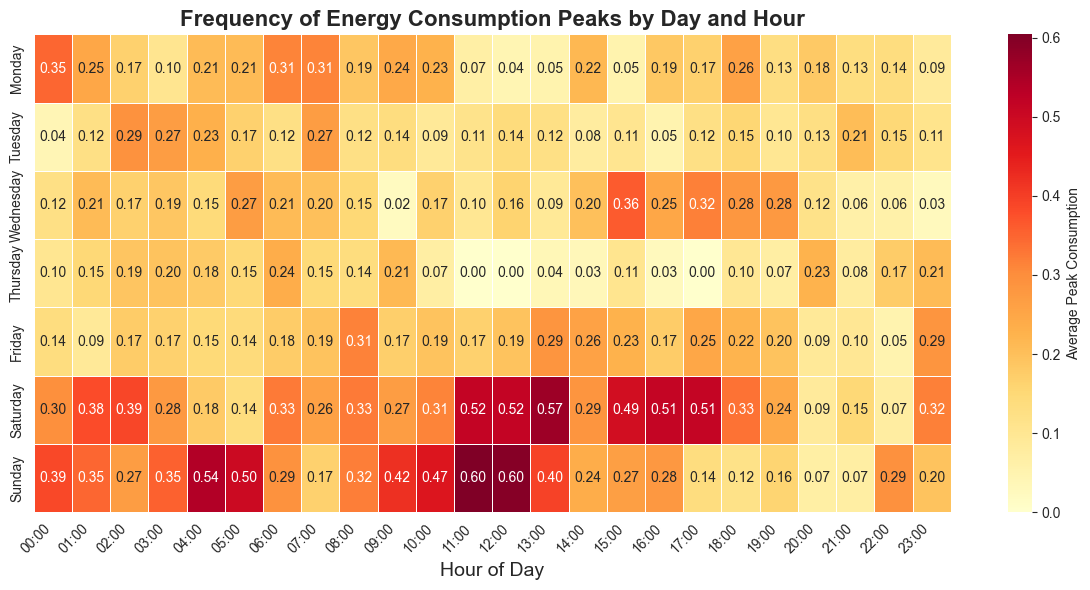

In [84]:
day_names = {
    0: 'Monday', 1: 'Tuesday', 2: 'Wednesday',
    3: 'Thursday', 4: 'Friday', 5: 'Saturday', 6: 'Sunday'
}

# Create sorted list of unique hours and corresponding labels
x_hour = sorted(df_cleaned['Hour'].unique())
hour_labels = [f"{int(h):02d}:00" for h in x_hour]

# Build pivot table for the heatmap
heatmap_data = (
    df_cleaned
    .assign(Day_of_Week_Name=lambda df: df['Day_of_Week'].map(day_names))
    .groupby(['Day_of_Week_Name', 'Hour'])['Peak_Consumption']
    .mean()
    .unstack()
)

# Reorder days Monday→Sunday
ordered_days = ['Monday','Tuesday','Wednesday','Thursday','Friday','Saturday','Sunday']
heatmap_data = heatmap_data.reindex(ordered_days)

# Plot the heatmap with custom x-labels
plt.figure(figsize=(12, 6))
ax = sns.heatmap(
    heatmap_data,
    cmap='YlOrRd',
    annot=True,
    fmt=".2f",
    linewidths=0.5,
    cbar_kws={'label': 'Average Peak Consumption'}
)

# Center tick marks in each cell and set hour labels
ax.set_xticks(np.arange(len(hour_labels)) + 0.5)
ax.set_xticklabels(hour_labels, rotation=45, ha='right')

ax.set_title("Frequency of Energy Consumption Peaks by Day and Hour", weight='bold', fontsize=16)
ax.set_xlabel("Hour of Day", fontsize=14)
ax.set_ylabel("", fontsize=14)
plt.tight_layout()
plt.savefig('energy_peaks_day_hours.png', dpi=300)
plt.show()


`Energy Consumption Distribution`

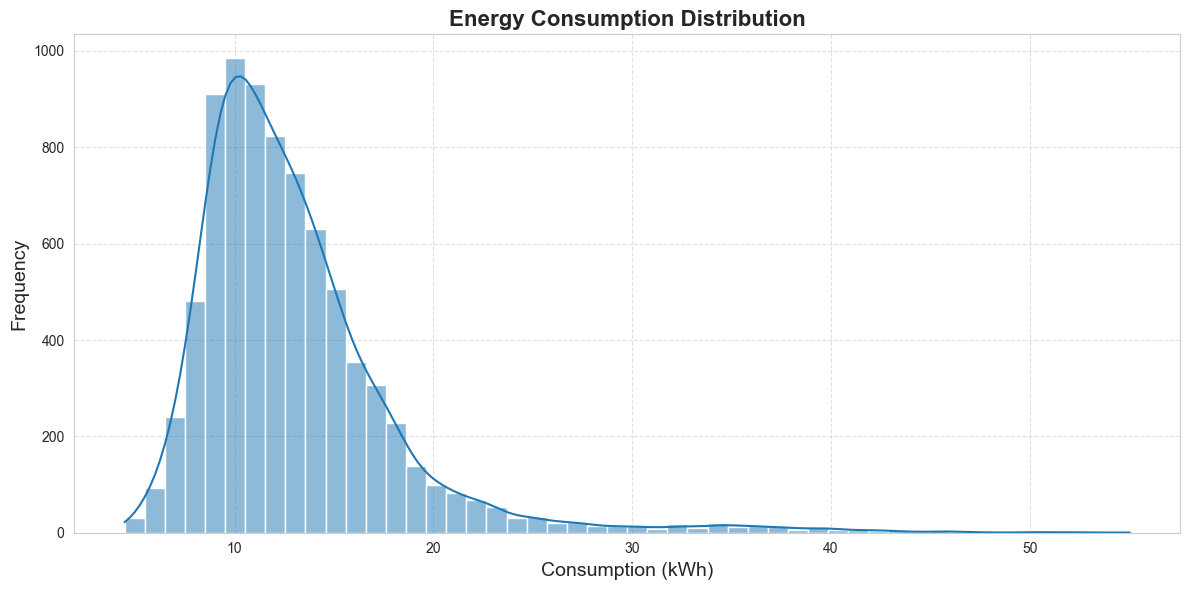

In [85]:
#Choose a palette with n colors
COLOR_PALETTE = sns.color_palette("tab10", 2)

# Creating the graph
fig, ax = plt.subplots(figsize=(12, 6))

# Leave background white
fig.patch.set_facecolor('white')  # fundo da figura
ax.set_facecolor('white')         # fundo do plot

# Histogram with density line
sns.histplot(
    merged['Total_Energy_Consumption'],
    kde=True,
    bins=50,
    color=COLOR_PALETTE[0],
    ax=ax
)

# Styling
ax.set_title('Energy Consumption Distribution', weight='bold', fontsize=16)
ax.set_xlabel('Consumption (kWh)', fontsize=14)
ax.set_ylabel('Frequency', fontsize=14)
ax.grid(True, linestyle='--', alpha=0.6)

plt.tight_layout()
plt.savefig('energy_consumption_distribution.png', dpi=300)
plt.show()


`Daily Energy Consumption and Average Temperature`

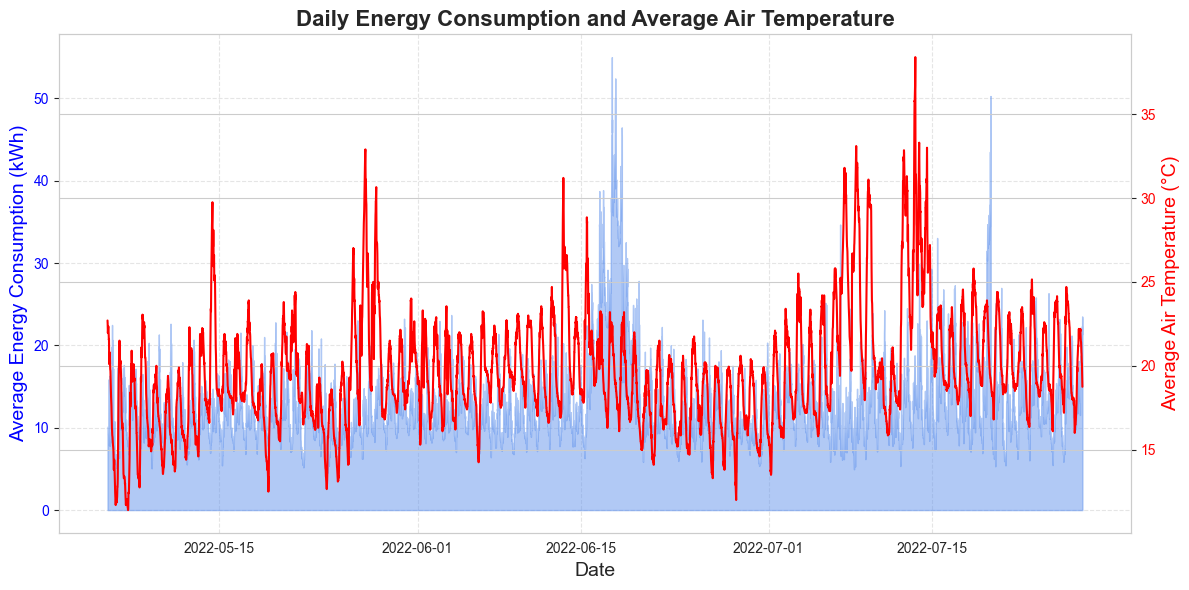

In [86]:
# Convert 'Time' to datetime
df['Time'] = pd.to_datetime(df['Time'])

# Create the chart
fig, ax1 = plt.subplots(figsize=(12, 6))

# Leave background white
fig.patch.set_facecolor('white')
ax1.set_facecolor('white')

# First axis: Energy Consumption
ax1.fill_between(df['Time'], df['Total_Energy_Consumption'], color='cornflowerblue', alpha=0.5, label='Total Energy Consumption')
ax1.set_xlabel('Date', fontsize=14)
ax1.set_ylabel('Average Energy Consumption (kWh)', color='blue', fontsize=14)
ax1.tick_params(axis='y', labelcolor='blue')

# Second axis: Average Temperature
ax2 = ax1.twinx()
ax2.plot(df['Time'], df['Avg_Temp'], color='red', label='Average Air Temperature')
ax2.set_ylabel('Average Air Temperature (°C)', color='red', fontsize=14)
ax2.tick_params(axis='y', labelcolor='red')

# Title
plt.title('Daily Energy Consumption and Average Air Temperature', weight='bold', fontsize=16)

# grid
ax1.grid(True, linestyle='--', alpha=0.5)

# Layout setting
fig.tight_layout()
plt.savefig('daily_energy_consumption_temp.png', dpi=300)

# plot graphic
plt.show()

`Average Energy Consumption by Hour and Day of the Week`

/var/folders/xj/vmtsvzgs6zj1l876xt4q0nkw0000gn/T/ipykernel_41074/984795446.py:52: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_yticklabels(ax.get_yticks(), fontsize=12)


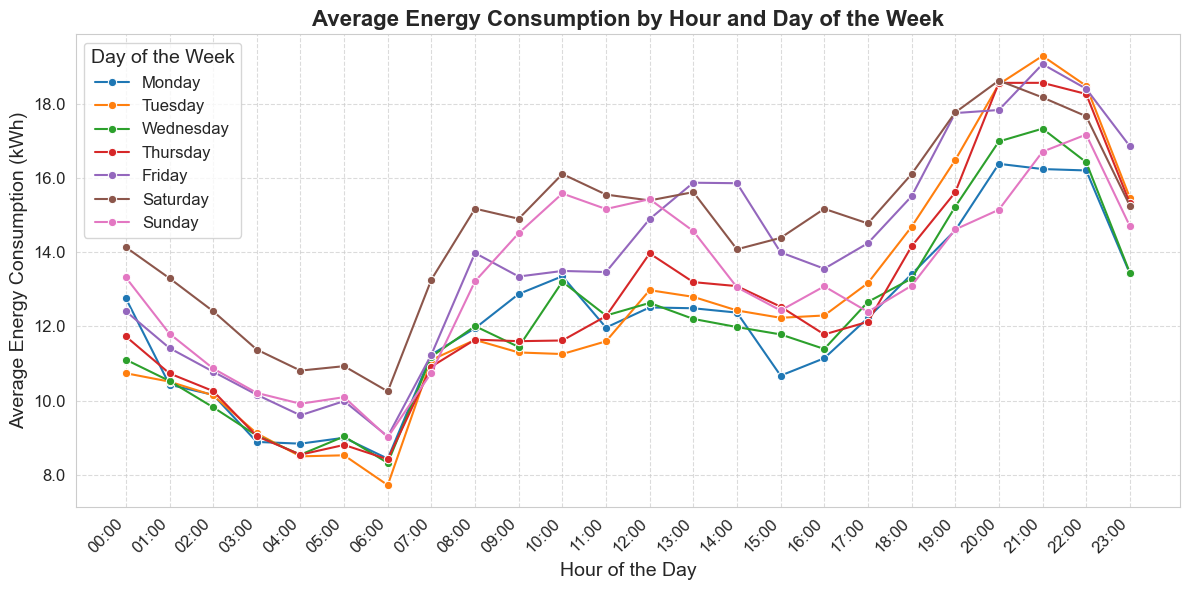

In [87]:
# Map numeric day to weekday names
df['Day_of_Week_Name'] = df['Day_of_Week'].map({
    0: 'Monday',
    1: 'Tuesday',
    2: 'Wednesday',
    3: 'Thursday',
    4: 'Friday',
    5: 'Saturday',
    6: 'Sunday'
})

# Group by weekday and hour
hourly_weekday_avg = (
    df
    .groupby(['Day_of_Week_Name', 'Hour'])['Total_Energy_Consumption']
    .mean()
    .reset_index()
)

# Define the correct weekday order
weekday_order = ['Monday','Tuesday','Wednesday','Thursday','Friday','Saturday','Sunday']

# Prepare hour labels
hour_labels = [f"{h:02d}:00" for h in range(24)]

# Create figure and axis
fig, ax = plt.subplots(figsize=(12, 6))
fig.patch.set_facecolor('white')
ax.set_facecolor('white')

# Line plot
sns.lineplot(
    data=hourly_weekday_avg,
    x='Hour',
    y='Total_Energy_Consumption',
    hue='Day_of_Week_Name',
    hue_order=weekday_order,
    marker='o',
    ax=ax
)

# Styling
ax.set_title('Average Energy Consumption by Hour and Day of the Week', fontsize=16, weight='bold')
ax.set_xlabel('Hour of the Day', fontsize=14)
ax.set_ylabel('Average Energy Consumption (kWh)', fontsize=14)

# Set hourly ticks and formatted labels
ax.set_xticks(range(24))
ax.set_xticklabels(hour_labels, rotation=45, ha='right', fontsize=12)

# Y-axis tick label size
ax.set_yticklabels(ax.get_yticks(), fontsize=12)

ax.legend(title='Day of the Week', fontsize=12, title_fontsize=14)
ax.grid(True, linestyle='--', alpha=0.7)

plt.tight_layout()
plt.savefig('daily_energy_consumption_weekday.png', dpi=300)
plt.show()

`Correlation Matrix`

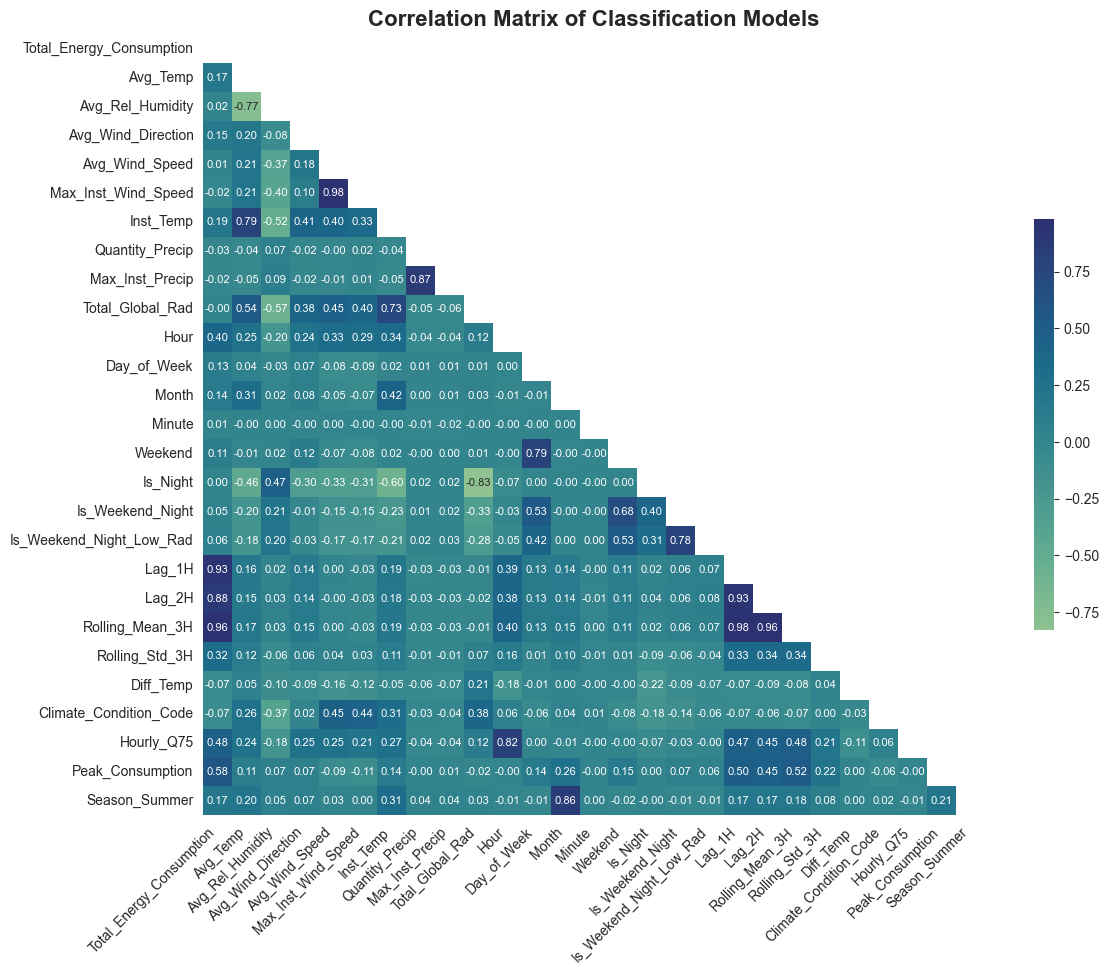

In [88]:
# Select numeric columns with nonzero variance
num_cols   = df.select_dtypes(include='number').columns
variables  = df[num_cols].loc[:, df[num_cols].std() != 0]
corr_matrix = variables.corr()

# Build the mask for the upper triangle
mask = np.triu(np.ones_like(corr_matrix, dtype=bool))

# Draw the heatmap
plt.figure(figsize=(12, 10))
ax = sns.heatmap(
    corr_matrix,
    mask=mask,
    cmap="crest",           
    center=0,
    annot=True,
    fmt=".2f",
    annot_kws={"size": 8},
    linewidths=0,           # no separation lines
    cbar_kws={"shrink": 0.5},
    square=True,
    xticklabels=True,
    yticklabels=True
)

# Remove any remaining grid or cell‐edge lines
ax.grid(False)                     # turn off the axes grid
# remove the default border
for spine in ax.spines.values():
    spine.set_visible(False)
# ensure that patches have no visible edge
if ax.collections:
    ax.collections[0].set_edgecolor("face")

# Tidy up the ticks and title
plt.xticks(rotation=45, ha='right', fontsize=10)
plt.yticks(rotation=0, fontsize=10)
plt.title("Correlation Matrix of Classification Models", fontsize=16, weight='bold')
plt.tight_layout()
plt.savefig('correlation_crest_clean.png', dpi=300)
plt.show()

In [89]:
# df.drop(['Max_Inst_Wind_Speed','Season_Summer', 'Max_Inst_Precip', 'Total_Energy_Consumption', 'Inst_Temp', 'Power_kW'],axis=1,inplace=True)

--- 
## 4. Model Selection and Training

In [90]:
from sklearn.preprocessing import RobustScaler
from imblearn.combine import SMOTEENN

df = df.copy()

# Feature selection
features = [
       'Avg_Temp', 'Avg_Rel_Humidity',
       'Avg_Wind_Direction', 'Avg_Wind_Speed', 'Max_Inst_Wind_Speed',
       'Inst_Temp', 'Quantity_Precip', 'Max_Inst_Precip', 'Total_Global_Rad',
       'Hour', 'Day_of_Week', 'Month', 'Minute', 'Weekend', 'Is_Night',
       'Is_Weekend_Night', 'Is_Weekend_Night_Low_Rad', 'Lag_1H',
       'Lag_2H', 'Rolling_Mean_3H', 'Rolling_Std_3H', 'Diff_Temp',
       'Climate_Condition_Code',
       'Season_Summer' 
]

X = df[features]
y = df['Peak_Consumption']

# Check original class distribution (before balancing)
print("Original class distribution (before SMOTEENN):")
print(y.value_counts())

# Split data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=42, stratify=y)

# Balance the dataset using SMOTEENN
smt = SMOTEENN(random_state=42, sampling_strategy=0.7)
X_resampled, y_resampled = smt.fit_resample(X_train, y_train)

# Class distribution after balancing
print("\nClass distribution after SMOTEENN:")
print(pd.Series(y_resampled).value_counts())

Original class distribution (before SMOTEENN):
Peak_Consumption
0    6000
1    2000
Name: count, dtype: int64

Class distribution after SMOTEENN:
Peak_Consumption
0    2589
1    1822
Name: count, dtype: int64


`Model XGBoost`

In [91]:
temp_xgb = XGBClassifier(scale_pos_weight=3, use_label_encoder=False, n_estimators=100, eval_metric='logloss', random_state=42)
temp_xgb.fit(X_resampled, y_resampled)

# Get feature importances
importances = temp_xgb.feature_importances_
feat_df = pd.DataFrame({'feature': features, 'importance': importances}).sort_values('importance', ascending=False)

# Keep only features with importance > 0
top_features = feat_df[feat_df['importance'] > 0]['feature'].tolist()
print("\nSelected top features:")
print(top_features)

# Filter resampled and test sets to keep only top features
X_resampled = pd.DataFrame(X_resampled, columns=features)[top_features]
X_test_selected = pd.DataFrame(X_test, columns=features)[top_features]
features = top_features  


Selected top features:
['Rolling_Mean_3H', 'Hour', 'Weekend', 'Total_Global_Rad', 'Rolling_Std_3H', 'Inst_Temp', 'Minute', 'Lag_2H', 'Max_Inst_Wind_Speed', 'Climate_Condition_Code', 'Avg_Wind_Speed', 'Avg_Rel_Humidity', 'Max_Inst_Precip', 'Avg_Wind_Direction', 'Lag_1H', 'Day_of_Week', 'Avg_Temp', 'Diff_Temp', 'Season_Summer', 'Month', 'Quantity_Precip', 'Is_Night', 'Is_Weekend_Night']


/Users/annycaroline/opt/anaconda3/envs/ml-energy/lib/python3.11/site-packages/xgboost/training.py:183: UserWarning: [20:10:15] WARNING: /Users/runner/miniforge3/conda-bld/xgboost-split_1745056754219/work/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


In [92]:
xgb = XGBClassifier(random_state=42, eval_metric='logloss')

param_dist = {
    'n_estimators': [100, 200, 300, 500],
    'max_depth': [3, 5, 7, 9],
    'learning_rate': [0.01, 0.05, 0.1, 0.2],
    'subsample': [0.6, 0.8, 1.0],
    'colsample_bytree': [0.6, 0.8, 1.0],
    'gamma': [0, 0.1, 0.3, 0.5],
    'reg_alpha': [0, 0.01, 0.1],
    'reg_lambda': [1, 1.5, 2.0]
}

cv=StratifiedKFold(n_splits=10, shuffle=True, random_state=42)
random_search = RandomizedSearchCV(
    estimator=xgb,
    param_distributions=param_dist,
    n_iter=50,
    scoring='f1_macro',
    cv=cv,
    verbose=1, # progress reporting.
    random_state=42,
    n_jobs=-1
)

# Train with selected features and sample weights
random_search.fit(X_resampled, y_resampled)  #sample_weight=weights
best_xgb = random_search.best_estimator_

print("\nBest hyperparameters found:")
print(random_search.best_params_)

Fitting 10 folds for each of 50 candidates, totalling 500 fits

Best hyperparameters found:
{'subsample': 0.6, 'reg_lambda': 1, 'reg_alpha': 0, 'n_estimators': 300, 'max_depth': 5, 'learning_rate': 0.1, 'gamma': 0.3, 'colsample_bytree': 0.8}


`Model Ensamble  RF + LR`

In [93]:
from sklearn.ensemble import RandomForestClassifier, VotingClassifier
from sklearn.linear_model import LogisticRegression
from scipy.stats import randint, uniform
import warnings
from sklearn.exceptions import ConvergenceWarning
warnings.filterwarnings("ignore", category=ConvergenceWarning) # Silence sklearn ConvergenceWarnings

# Model RF + LR
rf_model = RandomForestClassifier(random_state=42)
lr_model = LogisticRegression(max_iter=5000)

# Ensamble
ensemble = VotingClassifier(
    estimators=[('rf', rf_model), ('lr', lr_model)],
    voting='soft'
)

# Turning
param_dist = {
    'rf__n_estimators': randint(50, 300),
    'rf__max_depth': [None, 10, 20, 30],
    'lr__C': uniform(0.1, 0.5)
}

cv=StratifiedKFold(n_splits=10, shuffle=True, random_state=42)

# Randomized Search CV
random_search = RandomizedSearchCV(
    estimator=ensemble,
    param_distributions=param_dist,
    n_iter=50,  
    scoring='f1_macro',
    cv=cv,
    verbose=0, # progress reporting.
    random_state=42,
    n_jobs=-1
)

# Training
random_search.fit(X_resampled, y_resampled)

# Better performance
best_ensemble = random_search.best_estimator_

/Users/annycaroline/opt/anaconda3/envs/ml-energy/lib/python3.11/site-packages/sklearn/linear_model/_logistic.py:465: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. OF ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/Users/annycaroline/opt/anaconda3/envs/ml-energy/lib/python3.11/site-packages/sklearn/linear_model/_logistic.py:465: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. OF ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-le

## 5. Model Performance Evaluation

`Model Evaluation XGBoost`

In [94]:
# Predict directly (default threshold = 0.5)
y_pred = best_xgb.predict(X_test_selected)

# Evaluate with standard classification report
print("\nClassification Report:")
print(classification_report(y_test, y_pred))


Classification Report:
              precision    recall  f1-score   support

           0       0.94      0.92      0.93      1500
           1       0.77      0.83      0.80       500

    accuracy                           0.90      2000
   macro avg       0.86      0.87      0.86      2000
weighted avg       0.90      0.90      0.90      2000



`Model Evaluation Ensamble RF + LR`

In [95]:
# Performance
y_pred_ensemble = best_ensemble.predict(X_test_selected)
print("Best hyperparameters found:")
print(random_search.best_params_)
print("Ensemble performance:")
print(classification_report(y_test, y_pred_ensemble))

Best hyperparameters found:
{'lr__C': np.float64(0.5805860121746745), 'rf__max_depth': None, 'rf__n_estimators': 257}
Ensemble performance:
              precision    recall  f1-score   support

           0       0.93      0.92      0.93      1500
           1       0.77      0.79      0.78       500

    accuracy                           0.89      2000
   macro avg       0.85      0.86      0.85      2000
weighted avg       0.89      0.89      0.89      2000



## 5.1 Model Visualizations


Confusion Matrix:
[[1378  122]
 [  87  413]]


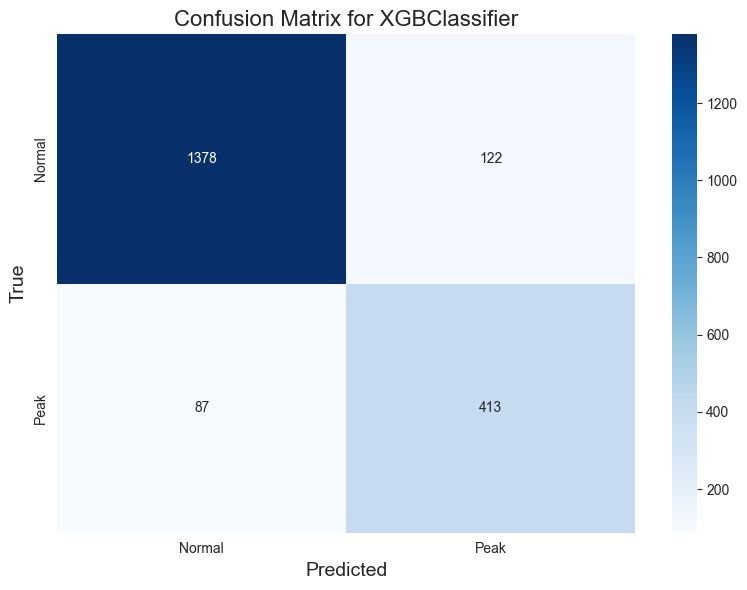


Confusion Matrix:
[[1385  115]
 [ 106  394]]


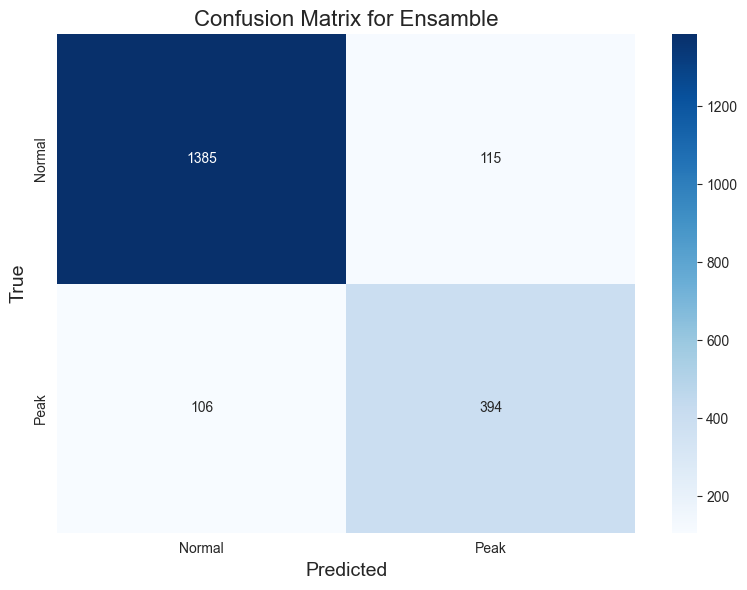

In [96]:
# ===== Confusion Matrix for XGBClassifier =====


cm = confusion_matrix(y_test, y_pred)
print("\nConfusion Matrix:")
print(cm)

plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', 
            xticklabels=['Normal', 'Peak'],
            yticklabels=['Normal', 'Peak'])
plt.title('Confusion Matrix for XGBClassifier', fontsize=16)
plt.xlabel('Predicted', fontsize=14)
plt.ylabel('True', fontsize=14)
plt.tight_layout()
plt.savefig('confusion_matrix_xgb.png', dpi=300)
plt.show()

# ===== Confusion Matrix for Ensamble =====

cm_ensamble = confusion_matrix(y_test, y_pred_ensemble)
print("\nConfusion Matrix:")
print(cm_ensamble)

plt.figure(figsize=(8, 6))
sns.heatmap(cm_ensamble, annot=True, fmt='d', cmap='Blues', 
            xticklabels=['Normal', 'Peak'],
            yticklabels=['Normal', 'Peak'])
plt.title('Confusion Matrix for Ensamble', fontsize=16)
plt.xlabel('Predicted', fontsize=14)
plt.ylabel('True', fontsize=14)
plt.tight_layout()
plt.savefig('confusion_matrix_ensamble.png', dpi=300)
plt.show()

In [97]:
# Reconstruct DataFrame with selected input features
X_test_df = pd.DataFrame(X_test_selected, columns=top_features)
X_test_df['True_Label'] = y_test.values
X_test_df['Predicted_Label'] = y_pred

# Identify error type
X_test_df['Error_Type'] = 'Correct'
X_test_df.loc[(X_test_df['True_Label'] == 1) & (X_test_df['Predicted_Label'] == 0), 'Error_Type'] = 'False Negative'
X_test_df.loc[(X_test_df['True_Label'] == 0) & (X_test_df['Predicted_Label'] == 1), 'Error_Type'] = 'False Positive'

# Split by error type
fn = X_test_df[X_test_df['Error_Type'] == 'False Negative']
fp = X_test_df[X_test_df['Error_Type'] == 'False Positive']
correct = X_test_df[X_test_df['Error_Type'] == 'Correct']

# Compare feature means by group
print("\n--- Mean of features by group ---")
print("False Negatives:")
print(fn[top_features].mean().round(2))

print("\nFalse Positives:")
print(fp[top_features].mean().round(2))

print("\nCorrect Predictions:")
print(correct[top_features].mean().round(2))


--- Mean of features by group ---
False Negatives:
Rolling_Mean_3H            12.98
Hour                       11.16
Weekend                     0.30
Total_Global_Rad          114.12
Rolling_Std_3H              1.26
Inst_Temp                  22.68
Minute                     26.38
Lag_2H                     12.44
Max_Inst_Wind_Speed         4.73
Climate_Condition_Code      1.47
Avg_Wind_Speed              3.13
Avg_Rel_Humidity           76.71
Max_Inst_Precip             0.00
Avg_Wind_Direction        213.24
Lag_1H                     12.48
Day_of_Week                 2.90
Avg_Temp                   19.79
Diff_Temp                  -0.08
Season_Summer               0.71
Month                       6.14
Quantity_Precip             0.00
Is_Night                    0.74
Is_Weekend_Night            0.22
dtype: float64

False Positives:
Rolling_Mean_3H            14.48
Hour                       10.63
Weekend                     0.45
Total_Global_Rad          208.10
Rolling_Std_3H          

`Prediction Error Analysis`

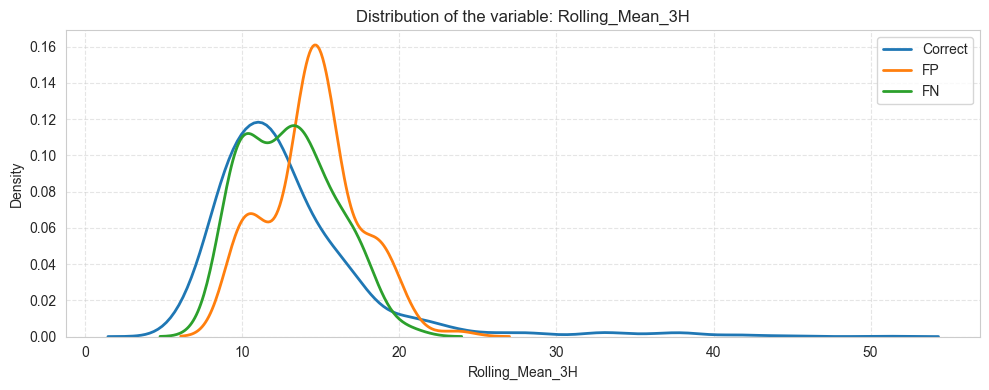

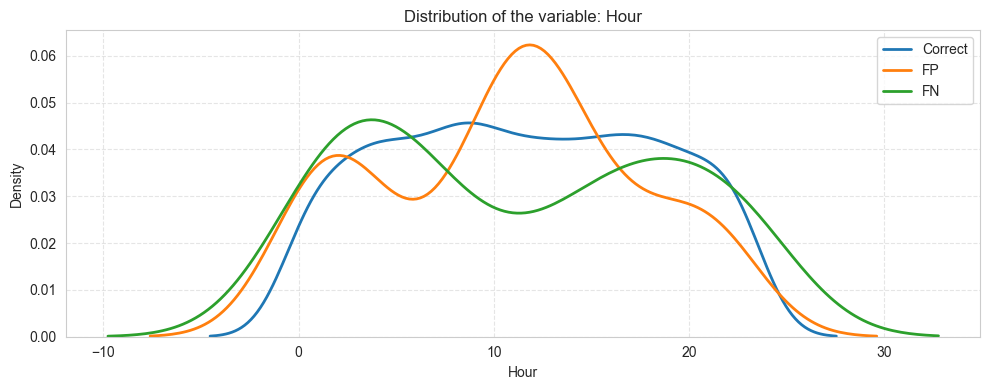

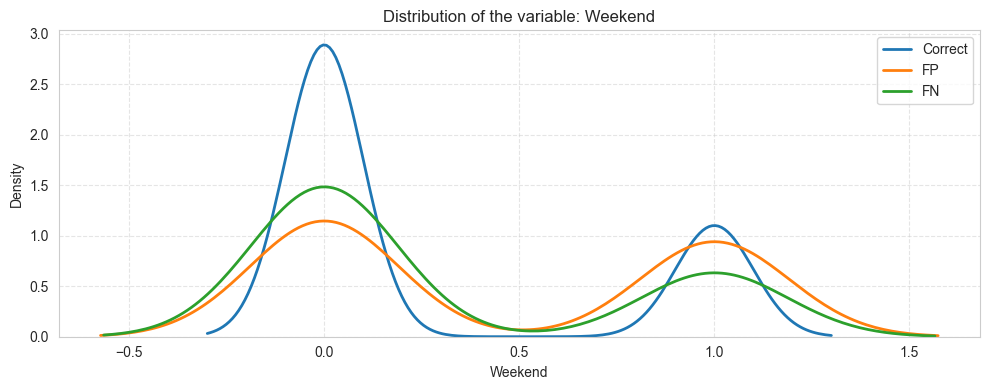

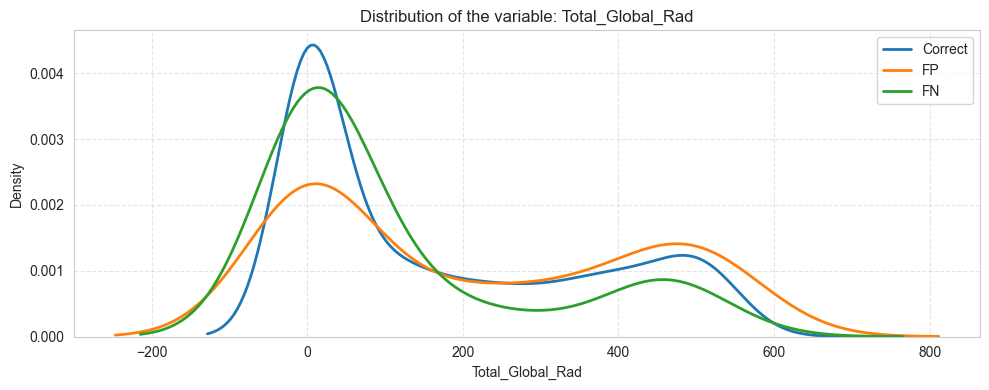

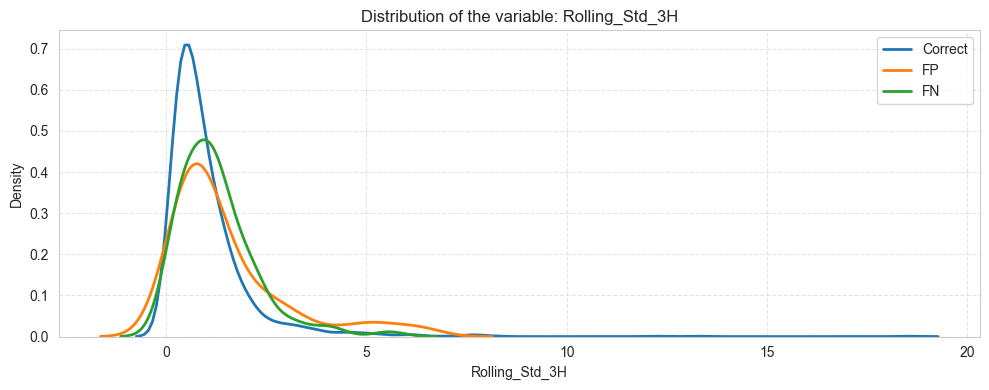

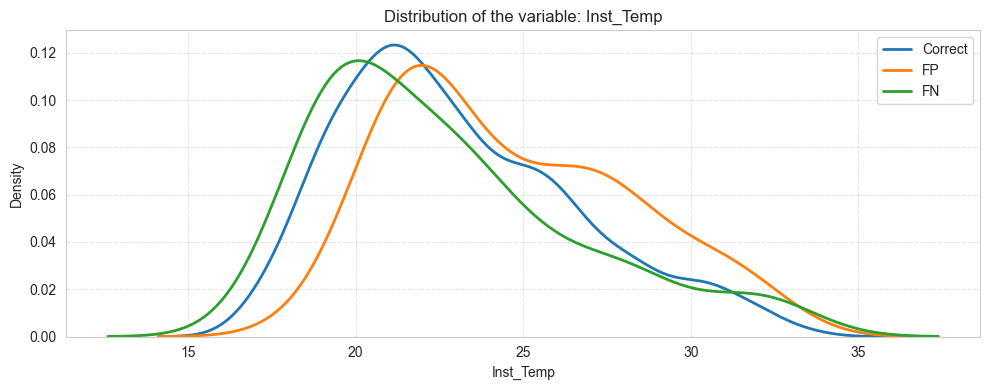

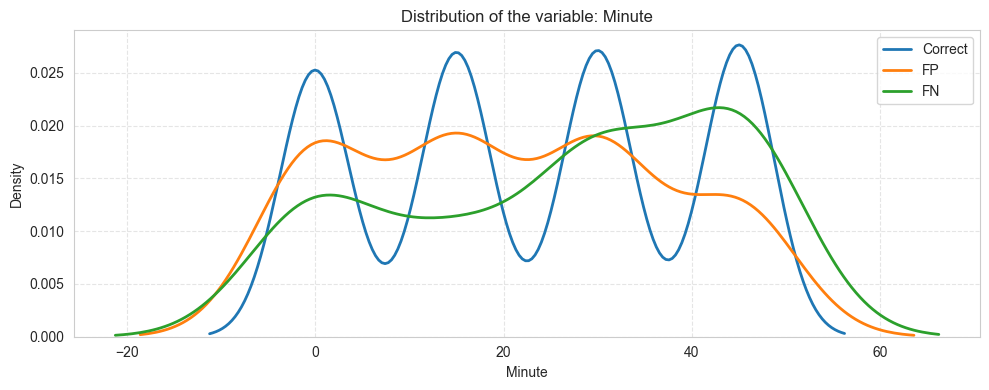

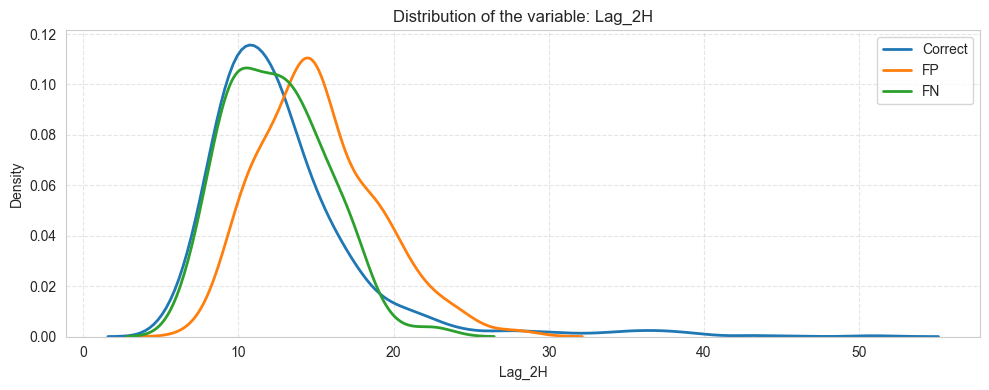

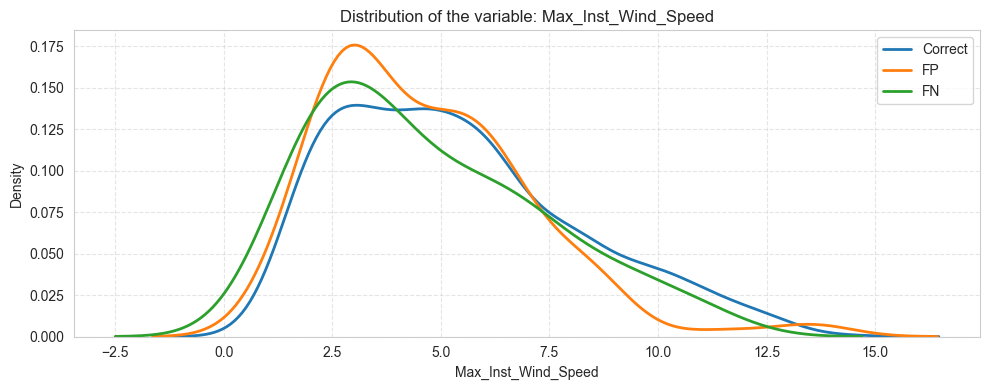

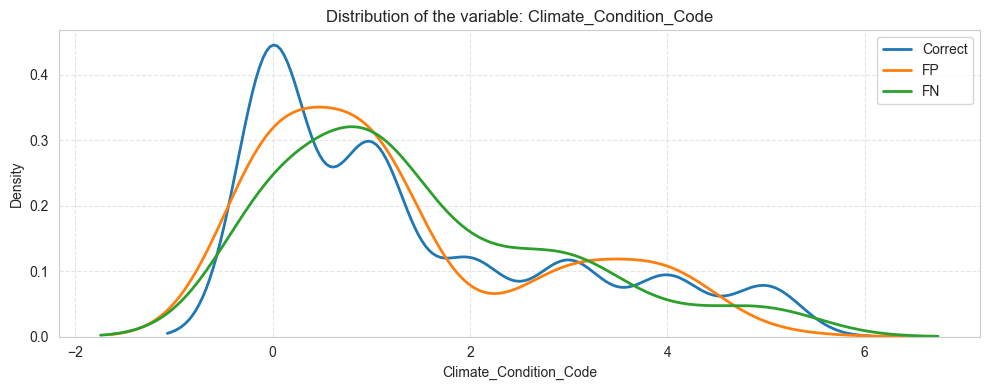

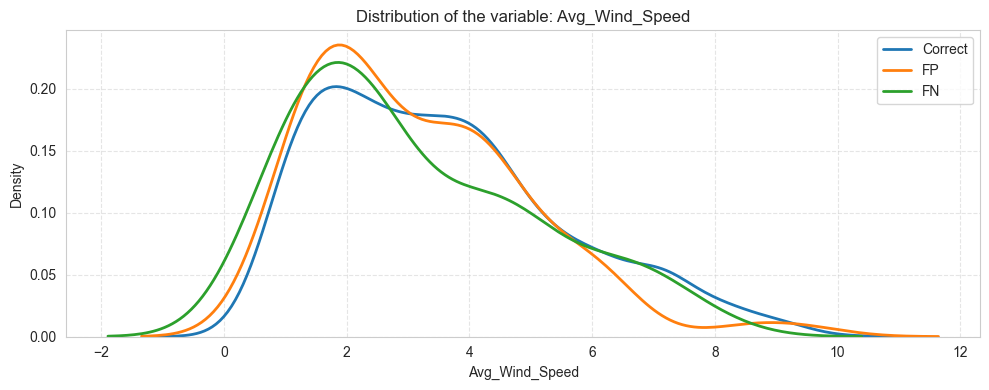

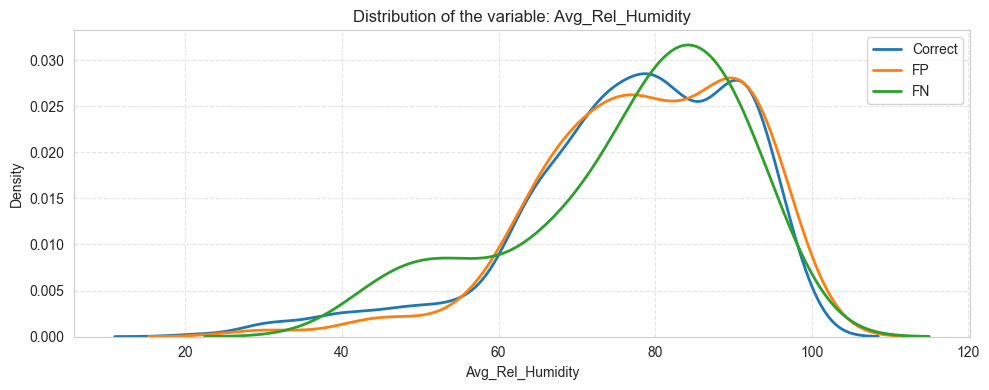

/var/folders/xj/vmtsvzgs6zj1l876xt4q0nkw0000gn/T/ipykernel_41074/4041681926.py:6: UserWarning: Dataset has 0 variance; skipping density estimate. Pass `warn_singular=False` to disable this warning.
  sns.kdeplot(fn[var], label='FN', linewidth=2)


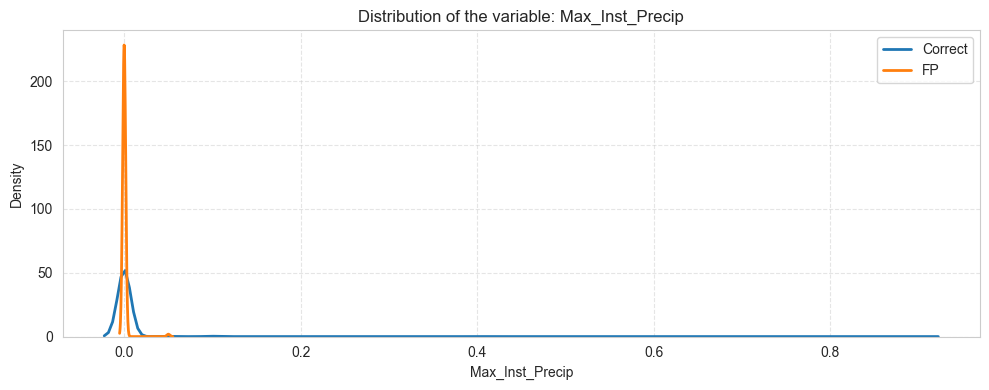

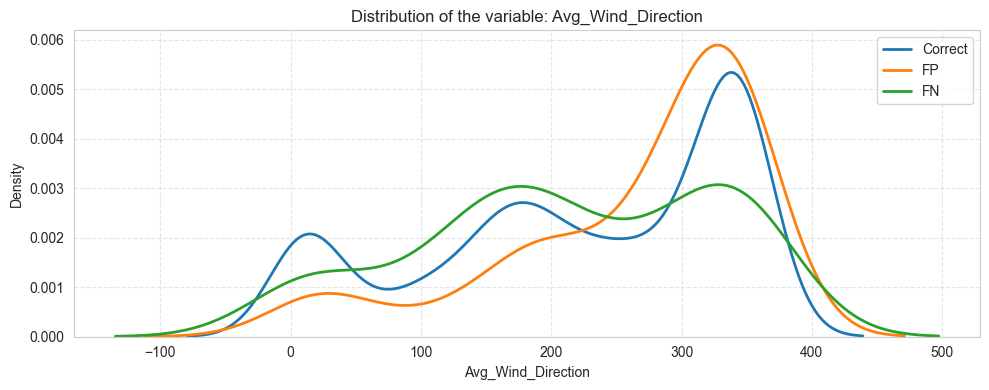

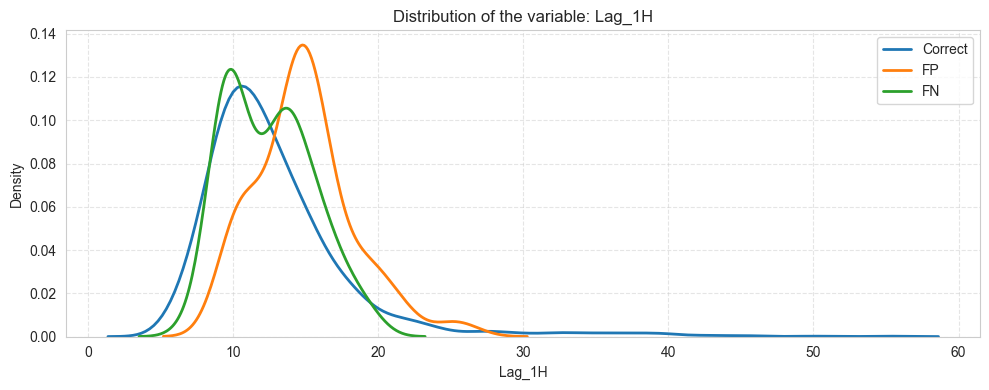

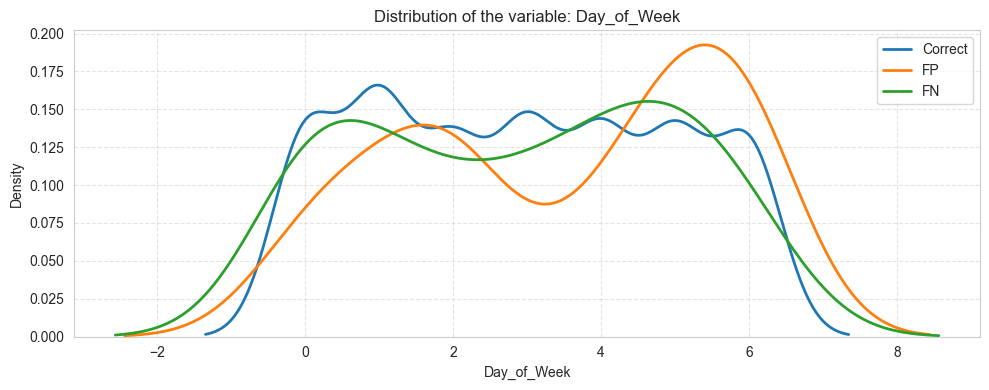

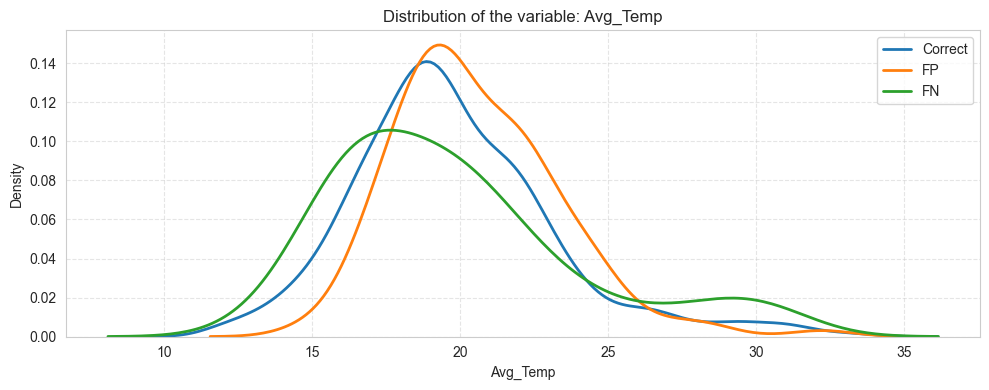

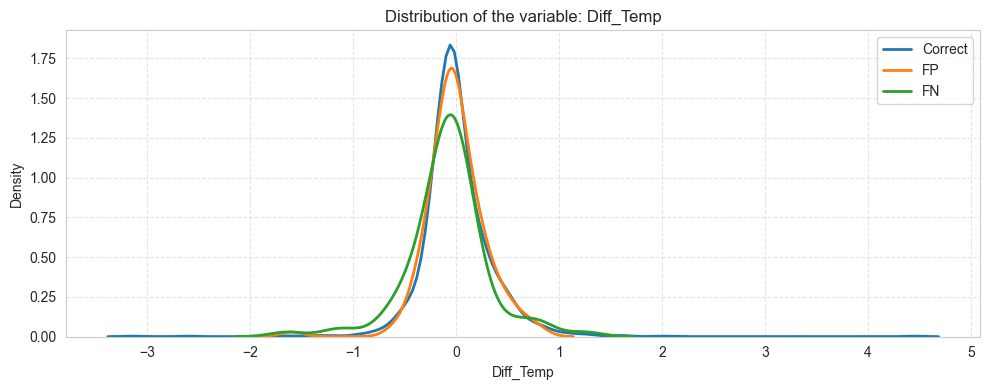

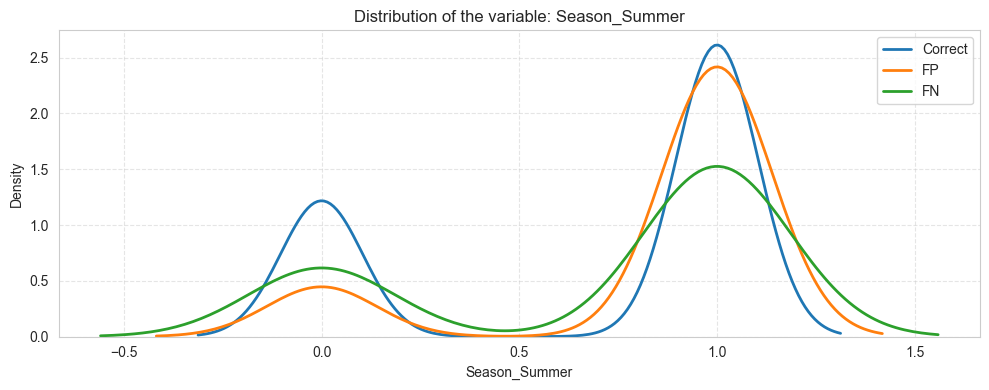

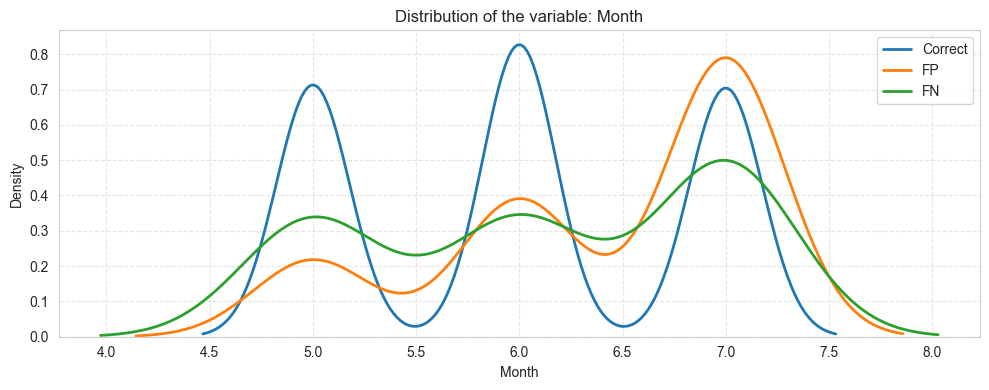

/var/folders/xj/vmtsvzgs6zj1l876xt4q0nkw0000gn/T/ipykernel_41074/4041681926.py:6: UserWarning: Dataset has 0 variance; skipping density estimate. Pass `warn_singular=False` to disable this warning.
  sns.kdeplot(fn[var], label='FN', linewidth=2)


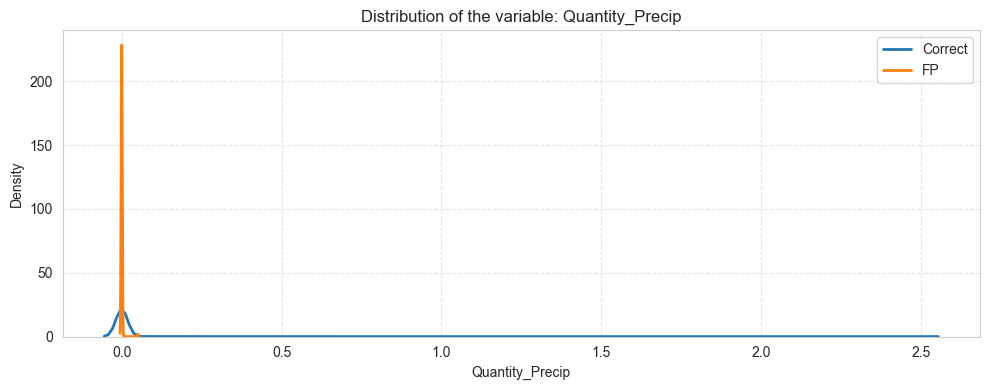

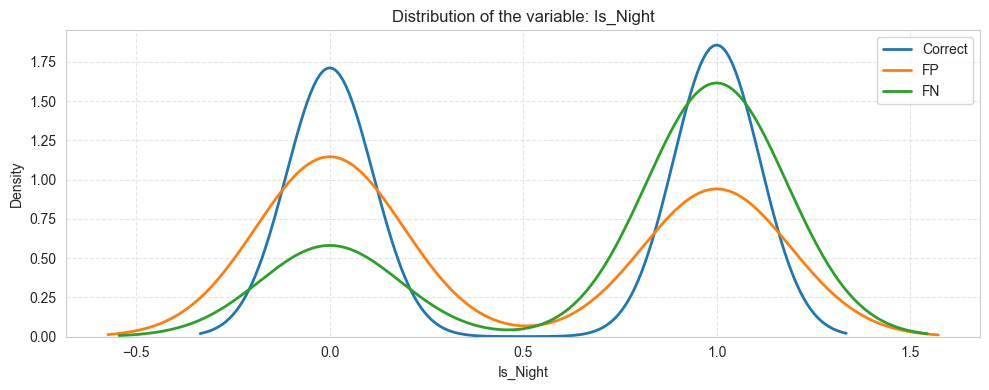

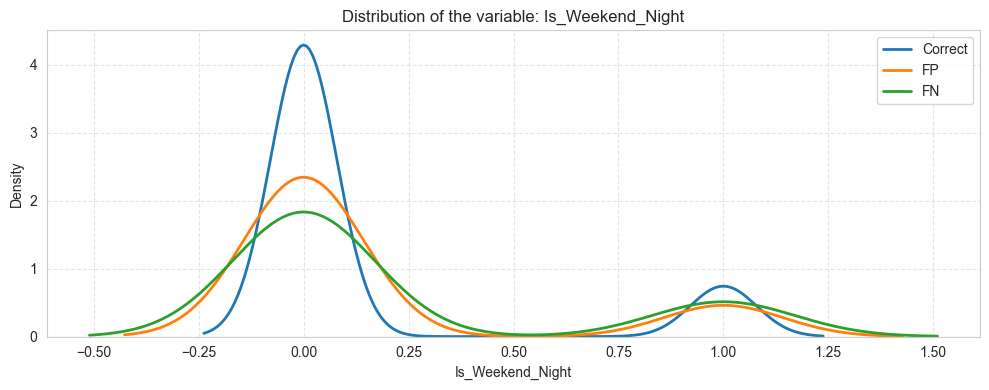

In [98]:
# Distribution of variables for visual analysis
for var in features:
    plt.figure(figsize=(10, 4))
    sns.kdeplot(correct[var], label='Correct', linewidth=2)
    sns.kdeplot(fp[var], label='FP', linewidth=2)
    sns.kdeplot(fn[var], label='FN', linewidth=2)
    plt.title(f'Distribution of the variable: {var}')
    plt.legend()
    plt.grid(True, linestyle='--', alpha=0.5)
    plt.tight_layout()
    plt.show()

`Importance Feature`

                   feature  importance
0          Rolling_Mean_3H    0.185138
21                Is_Night    0.146445
1                     Hour    0.102041
14                  Lag_1H    0.085439
5                Inst_Temp    0.044591
3         Total_Global_Rad    0.043860
11        Avg_Rel_Humidity    0.039770
7                   Lag_2H    0.034980
6                   Minute    0.034772
4           Rolling_Std_3H    0.031983
8      Max_Inst_Wind_Speed    0.028535
10          Avg_Wind_Speed    0.026950
13      Avg_Wind_Direction    0.022879
17               Diff_Temp    0.022655
16                Avg_Temp    0.021700
9   Climate_Condition_Code    0.021397
19                   Month    0.021188
15             Day_of_Week    0.020315
12         Max_Inst_Precip    0.019556
18           Season_Summer    0.018196
2                  Weekend    0.016571
22        Is_Weekend_Night    0.011039
20         Quantity_Precip    0.000000


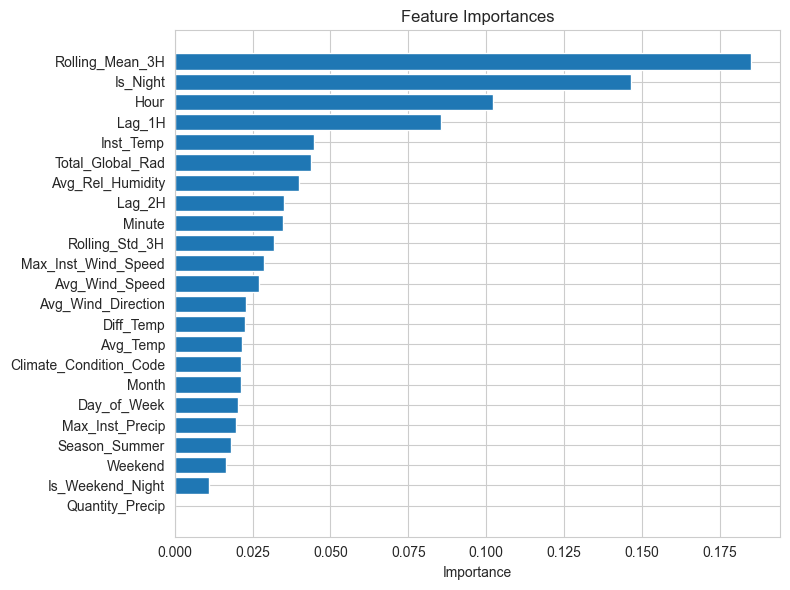

In [99]:
# Assuming 'best_xgb' is already trained:
importances = best_xgb.feature_importances_

# Build an ordered DataFrame
feat_df = pd.DataFrame({
    'feature': features,
    'importance': importances
}).sort_values('importance', ascending=False)

# Display the importances
print(feat_df)

# Plot the importances
plt.figure(figsize=(8, 6))
plt.barh(feat_df['feature'], feat_df['importance'])
plt.gca().invert_yaxis()  # place the most important at the top
plt.xlabel('Importance')
plt.title('Feature Importances')
plt.tight_layout()
plt.savefig('feature_importance.png', dpi=300)
plt.show()

`ROC-AUC Curve vs. Precision-Recall curve `

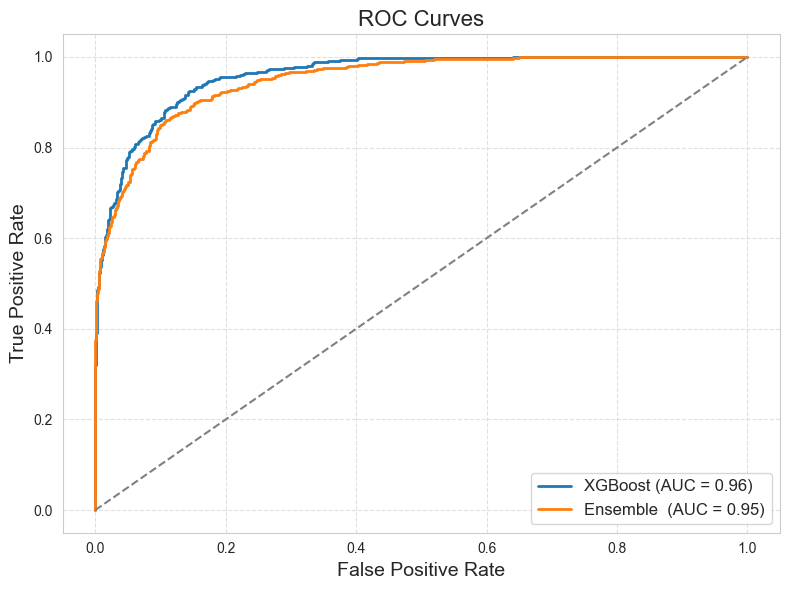

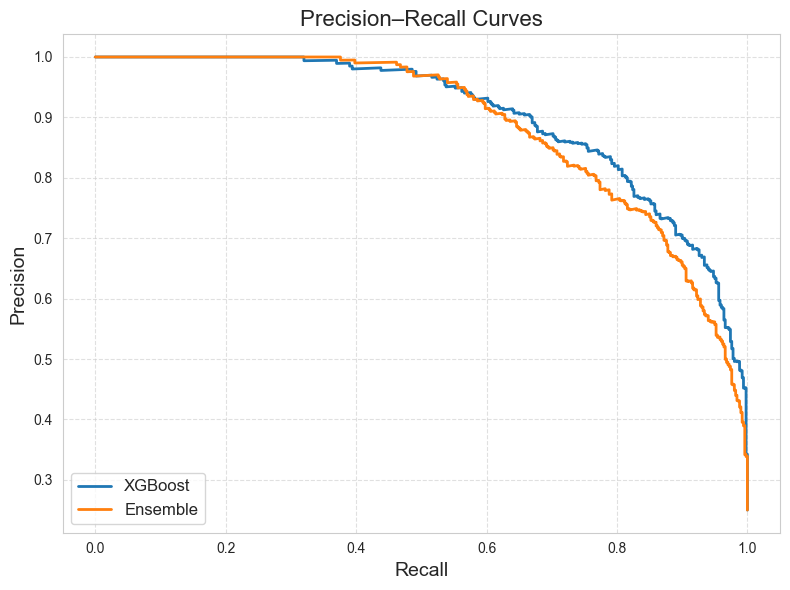

In [100]:
from sklearn.metrics import roc_curve, auc, precision_recall_curve

# Get predicted probabilities for both models
y_proba_xgb = best_xgb.predict_proba(X_test_selected)[:, 1]
y_proba_ens = best_ensemble.predict_proba(X_test_selected)[:, 1]

# ===== ROC Curve =====
fpr_xgb, tpr_xgb, _ = roc_curve(y_test, y_proba_xgb)
roc_auc_xgb         = auc(fpr_xgb, tpr_xgb)

fpr_ens, tpr_ens, _ = roc_curve(y_test, y_proba_ens)
roc_auc_ens         = auc(fpr_ens, tpr_ens)

plt.figure(figsize=(8, 6))
plt.plot(fpr_xgb, tpr_xgb,
         label=f'XGBoost (AUC = {roc_auc_xgb:.2f})',
         linewidth=2)
plt.plot(fpr_ens, tpr_ens,
         label=f'Ensemble  (AUC = {roc_auc_ens:.2f})',
         linewidth=2)
plt.plot([0, 1], [0, 1], linestyle='--', color='gray')
plt.xlabel('False Positive Rate', fontsize=14)
plt.ylabel('True Positive Rate', fontsize=14)
plt.title('ROC Curves', fontsize=16)
plt.legend(loc='lower right', fontsize=12)
plt.grid(True, linestyle='--', alpha=0.6)
plt.tight_layout()
plt.savefig('roc_auc_comparison.png', dpi=300)
plt.show()

# ===== Precision-Recall Curve =====
precision_xgb, recall_xgb, _ = precision_recall_curve(y_test, y_proba_xgb)
precision_ens, recall_ens, _ = precision_recall_curve(y_test, y_proba_ens)

plt.figure(figsize=(8, 6))
plt.plot(recall_xgb, precision_xgb,
         label='XGBoost', linewidth=2)
plt.plot(recall_ens, precision_ens,
         label='Ensemble', linewidth=2)
plt.xlabel('Recall', fontsize=14)
plt.ylabel('Precision', fontsize=14)
plt.title('Precision–Recall Curves', fontsize=16)
plt.legend(loc='lower left', fontsize=12)
plt.grid(True, linestyle='--', alpha=0.6)
plt.tight_layout()
plt.savefig('pr_comparison.png', dpi=300)
plt.show()

`Predictions did by Model`

In [101]:
# Uses the names of the features in the order expected by the model
expected_features = best_xgb.get_booster(). feature_names

# Creates new DataFrame with columns in the correct order
X_ordered = df_cleaned[expected_features]

# Makes the forecast with columns in the correct order
df_cleaned['Predicted_Peak'] = best_xgb.predict(X_ordered)

# Filters the schedules with peak forecast
predicted_peaks = df_cleaned[df_cleaned['Predicted_Peak'] == 1]

# Displays the data of interest
predicted_peaks[['Time', 'Lag_1H', 'Rolling_Mean_3H',
                       'Avg_Rel_Humidity', 'Total_Global_Rad', 'Avg_Temp', 'Inst_Temp',
                       'Avg_Wind_Speed', 'Day_of_Week', 'Predicted_Peak']]. head()

,Time,Lag_1H,Rolling_Mean_3H,Avg_Rel_Humidity,Total_Global_Rad,Avg_Temp,Inst_Temp,Avg_Wind_Speed,Day_of_Week,Predicted_Peak
15,2022-05-05 15:45:00,13.600,12.700667,67.0,406.85,20.35,25.15,4.65,3,1
34,2022-05-05 20:30:00,17.190,16.192667,81.0,0.00,16.80,19.20,2.20,3,1
41,2022-05-05 22:15:00,11.966,14.319583,86.5,0.00,15.75,18.25,1.75,3,1
42,2022-05-05 22:30:00,20.665,15.624000,87.0,0.00,15.60,18.20,2.00,3,1
81,2022-05-06 08:15:00,10.567,11.622667,99.0,143.70,12.80,17.65,1.65,4,1
